In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/PSIQUIATRÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=127.9, y1=114.7
Page 1, Q1, A: Yellow pixels: 1
Page 1, Q1, A: Total non-white pixels: 476
Page 1, Q1, A: Yellow percentage: 0.2%


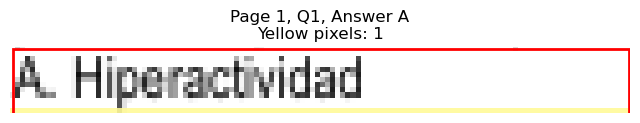

Page 1, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=150.5, y1=127.3
Page 1, Q1, B: Yellow pixels: 1386
Page 1, Q1, B: Total non-white pixels: 2030
Page 1, Q1, B: Yellow percentage: 68.3%


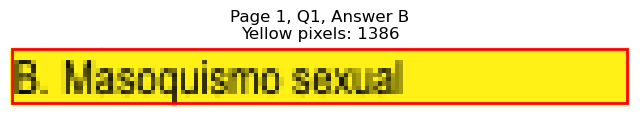

Page 1, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=378.2, y1=114.7
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 299
Page 1, Q1, C: Yellow percentage: 0.0%


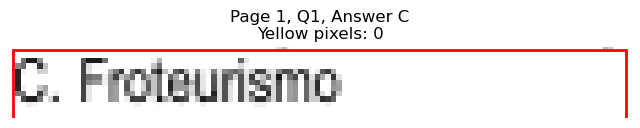

Page 1, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=377.7, y1=127.3
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 288
Page 1, Q1, D: Yellow percentage: 0.0%


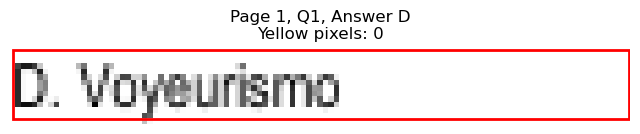


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)
Page 1, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=143.1, y1=190.4
Page 1, Q2, A: Yellow pixels: 138
Page 1, Q2, A: Total non-white pixels: 539
Page 1, Q2, A: Yellow percentage: 25.6%


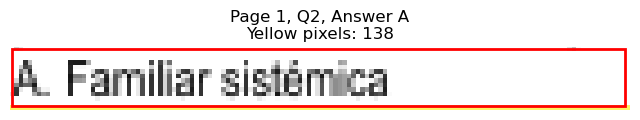

Page 1, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=156.0, y1=203.0
Page 1, Q2, B: Yellow pixels: 1619
Page 1, Q2, B: Total non-white pixels: 1963
Page 1, Q2, B: Yellow percentage: 82.5%


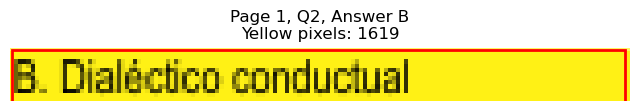

Page 1, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=376.7, y1=190.4
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 282
Page 1, Q2, C: Yellow percentage: 0.0%


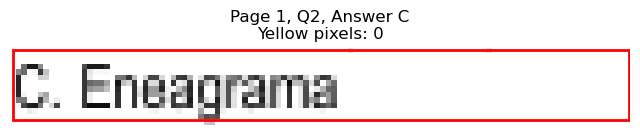

Page 1, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=385.7, y1=203.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 341
Page 1, Q2, D: Yellow percentage: 0.0%


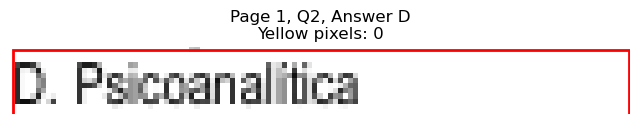


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)
Page 1, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=205.7, y1=266.1
Page 1, Q3, A: Yellow pixels: 2045
Page 1, Q3, A: Total non-white pixels: 2800
Page 1, Q3, A: Yellow percentage: 73.0%


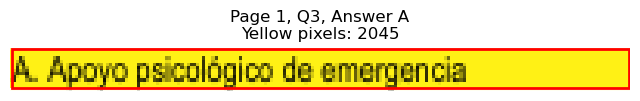

Page 1, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=261.4, y1=278.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 1150
Page 1, Q3, B: Yellow percentage: 0.0%


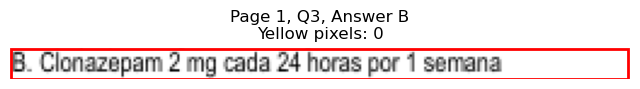

Page 1, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=511.7, y1=266.1
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 982
Page 1, Q3, C: Yellow percentage: 0.0%


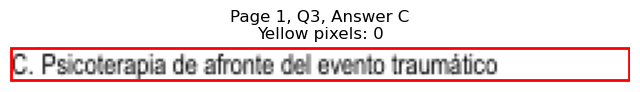

Page 1, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=507.7, y1=278.7
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 877
Page 1, Q3, D: Yellow percentage: 0.0%


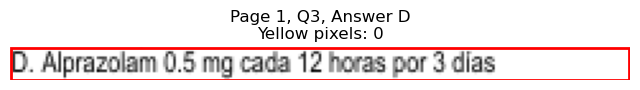


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)
Page 1, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=113.9, y1=316.6
Page 1, Q4, A: Yellow pixels: 1201
Page 1, Q4, A: Total non-white pixels: 1409
Page 1, Q4, A: Yellow percentage: 85.2%


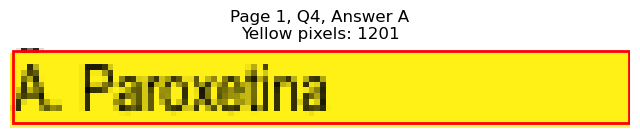

Page 1, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=132.5, y1=329.2
Page 1, Q4, B: Yellow pixels: 127
Page 1, Q4, B: Total non-white pixels: 509
Page 1, Q4, B: Yellow percentage: 25.0%


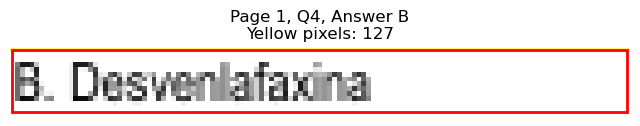

Page 1, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=368.7, y1=316.6
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 255
Page 1, Q4, C: Yellow percentage: 0.0%


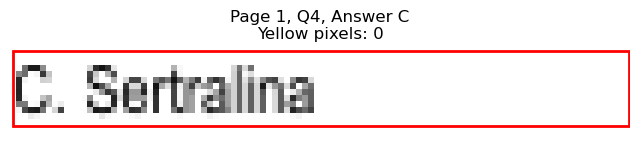

Page 1, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=382.3, y1=329.2
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 331
Page 1, Q4, D: Yellow percentage: 0.0%


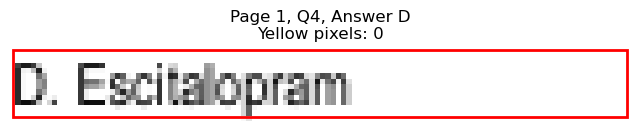


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)
Page 1, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=105.9, y1=379.8
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 227
Page 1, Q5, A: Yellow percentage: 0.0%


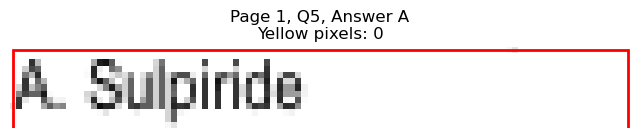

Page 1, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=110.9, y1=392.4
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 240
Page 1, Q5, B: Yellow percentage: 0.0%


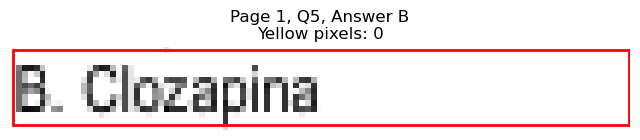

Page 1, Q5 - C: Detected box: x0=315.4, y0=304.0, x1=368.7, y1=316.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 255
Page 1, Q5, C: Yellow percentage: 0.0%


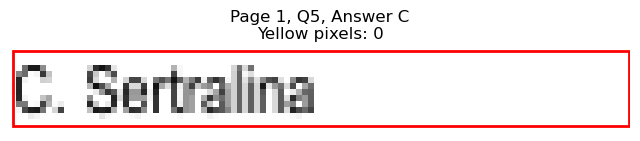

Page 1, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=375.7, y1=392.4
Page 1, Q5, D: Yellow pixels: 1122
Page 1, Q5, D: Total non-white pixels: 1554
Page 1, Q5, D: Yellow percentage: 72.2%


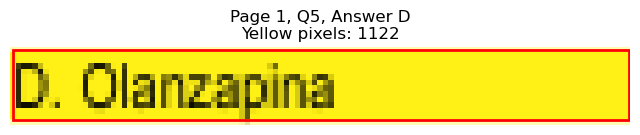


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)
Page 1, Q6 - A: Detected box: x0=56.6, y0=468.1, x1=97.9, y1=480.7
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 190
Page 1, Q6, A: Yellow percentage: 0.0%


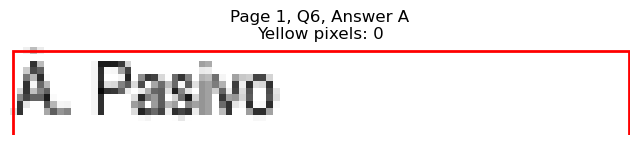

Page 1, Q6 - B: Detected box: x0=56.6, y0=480.8, x1=120.0, y1=493.4
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 317
Page 1, Q6, B: Yellow percentage: 0.0%


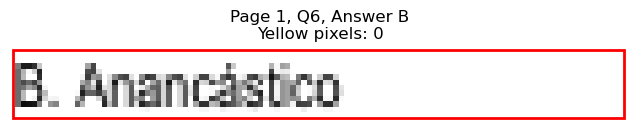

Page 1, Q6 - C: Detected box: x0=315.4, y0=468.1, x1=383.7, y1=480.7
Page 1, Q6, C: Yellow pixels: 1293
Page 1, Q6, C: Total non-white pixels: 1547
Page 1, Q6, C: Yellow percentage: 83.6%


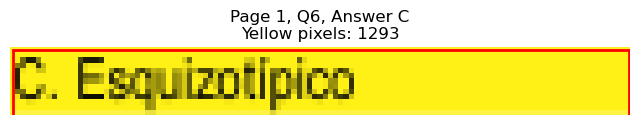

Page 1, Q6 - D: Detected box: x0=315.4, y0=480.8, x1=367.6, y1=493.4
Page 1, Q6, D: Yellow pixels: 103
Page 1, Q6, D: Total non-white pixels: 340
Page 1, Q6, D: Yellow percentage: 30.3%


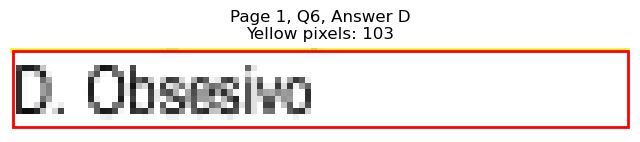


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)
Page 1, Q7 - A: Detected box: x0=56.6, y0=518.6, x1=179.2, y1=531.2
Page 1, Q7, A: Yellow pixels: 1753
Page 1, Q7, A: Total non-white pixels: 2436
Page 1, Q7, A: Yellow percentage: 72.0%


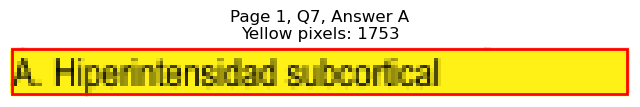

Page 1, Q7 - B: Detected box: x0=56.6, y0=531.2, x1=157.6, y1=543.8
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 652
Page 1, Q7, B: Yellow percentage: 0.0%


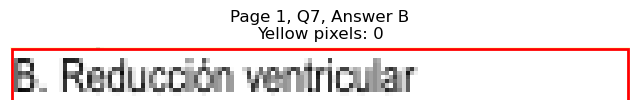

Page 1, Q7 - C: Detected box: x0=315.4, y0=518.6, x1=425.8, y1=531.2
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 579
Page 1, Q7, C: Yellow percentage: 0.0%


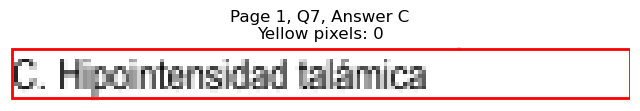

Page 1, Q7 - D: Detected box: x0=315.4, y0=531.2, x1=427.4, y1=543.8
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 527
Page 1, Q7, D: Yellow percentage: 0.0%


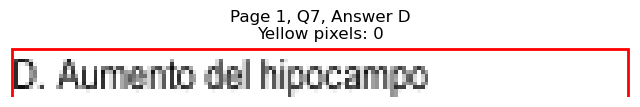


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)
Page 1, Q8 - A: Detected box: x0=56.6, y0=594.3, x1=134.1, y1=606.9
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 372
Page 1, Q8, A: Yellow percentage: 0.0%


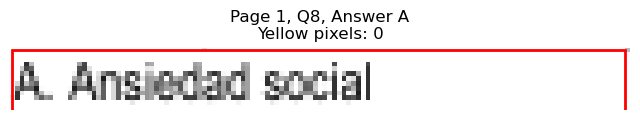

Page 1, Q8 - B: Detected box: x0=56.6, y0=606.9, x1=98.9, y1=619.5
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 199
Page 1, Q8, B: Yellow percentage: 0.0%


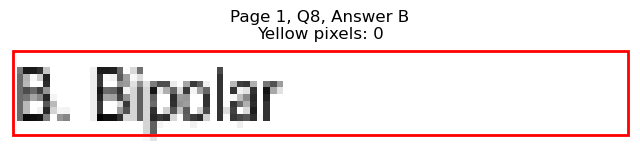

Page 1, Q8 - C: Detected box: x0=315.4, y0=594.3, x1=421.9, y1=606.9
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 689
Page 1, Q8, C: Yellow percentage: 0.0%


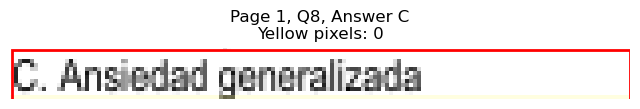

Page 1, Q8 - D: Detected box: x0=315.4, y0=606.9, x1=414.3, y1=619.5
Page 1, Q8, D: Yellow pixels: 1546
Page 1, Q8, D: Total non-white pixels: 2100
Page 1, Q8, D: Yellow percentage: 73.6%


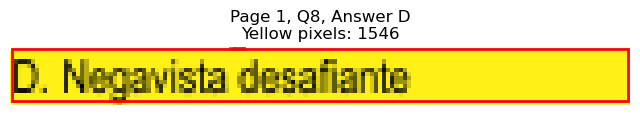


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)
Page 1, Q9 - A: Detected box: x0=56.6, y0=670.0, x1=130.5, y1=682.7
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 366
Page 1, Q9, A: Yellow percentage: 0.0%


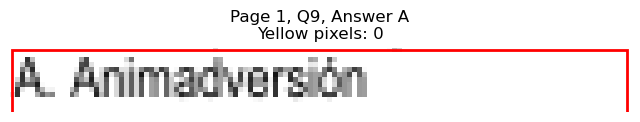

Page 1, Q9 - B: Detected box: x0=56.6, y0=682.6, x1=113.9, y1=695.3
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 264
Page 1, Q9, B: Yellow percentage: 0.0%


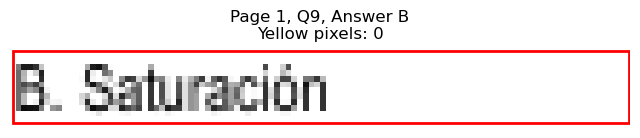

Page 1, Q9 - C: Detected box: x0=315.4, y0=670.0, x1=368.2, y1=682.7
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 349
Page 1, Q9, C: Yellow percentage: 0.0%


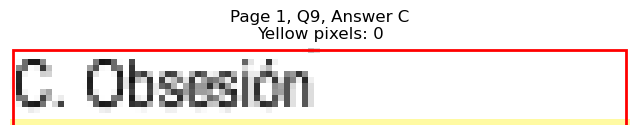

Page 1, Q9 - D: Detected box: x0=315.4, y0=682.6, x1=375.3, y1=695.3
Page 1, Q9, D: Yellow pixels: 1115
Page 1, Q9, D: Total non-white pixels: 1554
Page 1, Q9, D: Yellow percentage: 71.8%


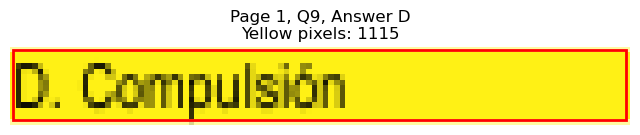


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)

Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=253.5, y1=114.7
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 967
Page 2, Q1, A: Yellow percentage: 0.0%


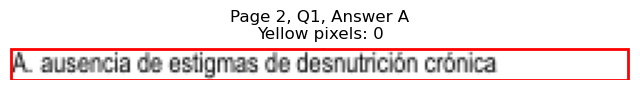

Page 2, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=224.3, y1=127.3
Page 2, Q1, B: Yellow pixels: 219
Page 2, Q1, B: Total non-white pixels: 979
Page 2, Q1, B: Yellow percentage: 22.4%


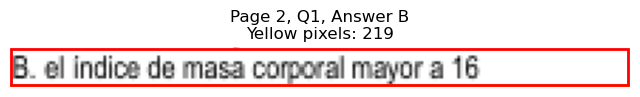

Page 2, Q1 - C: Detected box: x0=56.6, y0=127.2, x1=153.0, y1=139.9
Page 2, Q1, C: Yellow pixels: 1574
Page 2, Q1, C: Total non-white pixels: 1924
Page 2, Q1, C: Yellow percentage: 81.8%


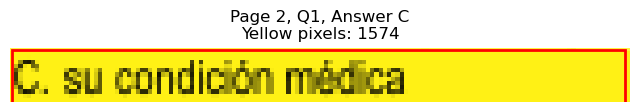

Page 2, Q1 - D: Detected box: x0=56.6, y0=139.9, x1=319.0, y1=152.6
Page 2, Q1, D: Yellow pixels: 314
Page 2, Q1, D: Total non-white pixels: 1579
Page 2, Q1, D: Yellow percentage: 19.9%


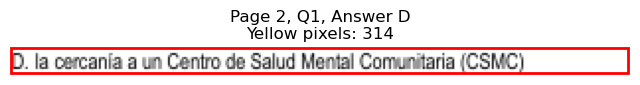


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)
Page 2, Q2 - A: Detected box: x0=56.6, y0=202.9, x1=85.8, y1=215.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 132
Page 2, Q2, A: Yellow percentage: 0.0%


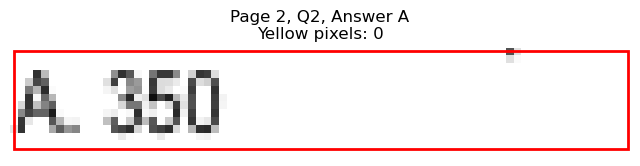

Page 2, Q2 - B: Detected box: x0=56.6, y0=215.6, x1=80.9, y1=228.3
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 111
Page 2, Q2, B: Yellow percentage: 0.0%


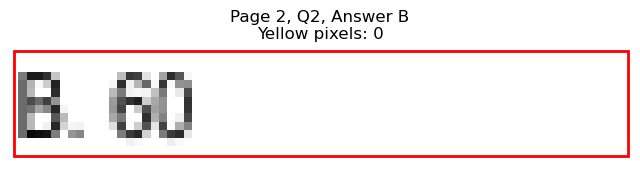

Page 2, Q2 - C: Detected box: x0=315.4, y0=202.9, x1=345.1, y1=215.6
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 112
Page 2, Q2, C: Yellow percentage: 0.0%


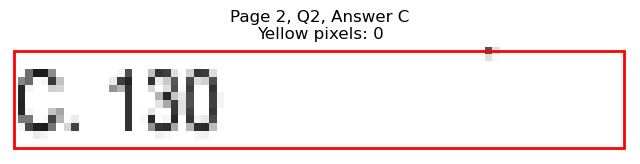

Page 2, Q2 - D: Detected box: x0=315.4, y0=215.6, x1=345.1, y1=228.3
Page 2, Q2, D: Yellow pixels: 892
Page 2, Q2, D: Total non-white pixels: 1134
Page 2, Q2, D: Yellow percentage: 78.7%


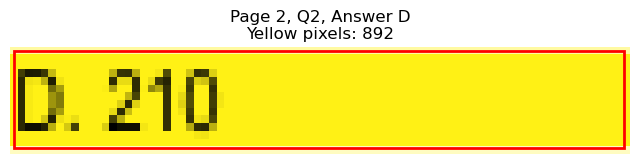


Page 2, Q2 - Selected Answer: D (based on yellow pixel count)
Page 2, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=160.6, y1=266.1
Page 2, Q3, A: Yellow pixels: 155
Page 2, Q3, A: Total non-white pixels: 651
Page 2, Q3, A: Yellow percentage: 23.8%


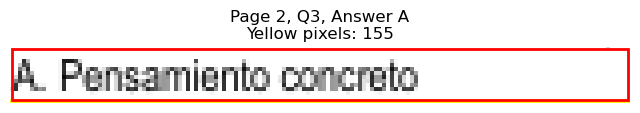

Page 2, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=150.0, y1=278.7
Page 2, Q3, B: Yellow pixels: 1531
Page 2, Q3, B: Total non-white pixels: 1885
Page 2, Q3, B: Yellow percentage: 81.2%


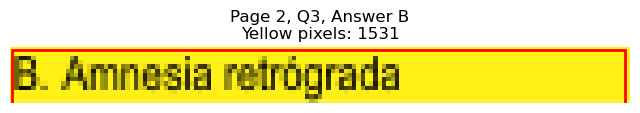

Page 2, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=423.9, y1=266.1
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 542
Page 2, Q3, C: Yellow percentage: 0.0%


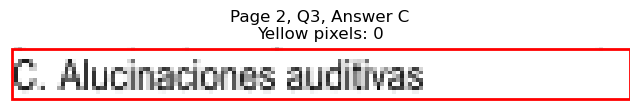

Page 2, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=408.8, y1=278.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 471
Page 2, Q3, D: Yellow percentage: 0.0%


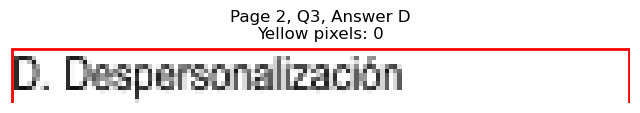


Page 2, Q3 - Selected Answer: B (based on yellow pixel count)
Page 2, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=139.5, y1=329.2
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 383
Page 2, Q4, A: Yellow percentage: 0.0%


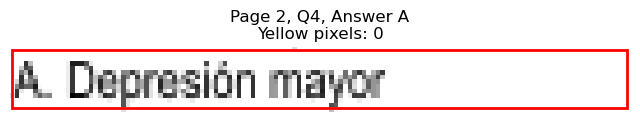

Page 2, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=155.5, y1=341.8
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 488
Page 2, Q4, B: Yellow percentage: 0.0%


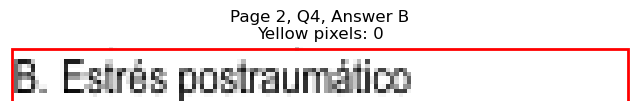

Page 2, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=363.2, y1=329.2
Page 2, Q4, C: Yellow pixels: 1003
Page 2, Q4, C: Total non-white pixels: 1386
Page 2, Q4, C: Yellow percentage: 72.4%


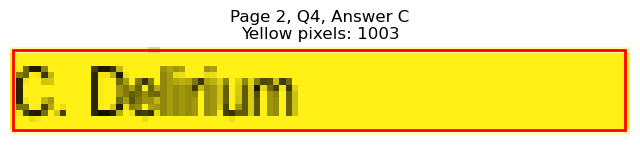

Page 2, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=370.7, y1=341.8
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 354
Page 2, Q4, D: Yellow percentage: 0.0%


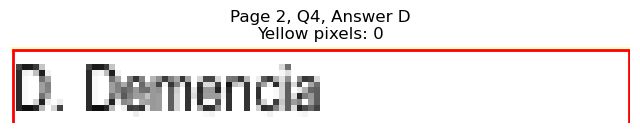


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)
Page 2, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=214.8, y1=379.8
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 796
Page 2, Q5, A: Yellow percentage: 0.0%


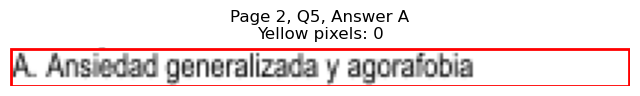

Page 2, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=158.5, y1=392.4
Page 2, Q5, B: Yellow pixels: 153
Page 2, Q5, B: Total non-white pixels: 651
Page 2, Q5, B: Yellow percentage: 23.5%


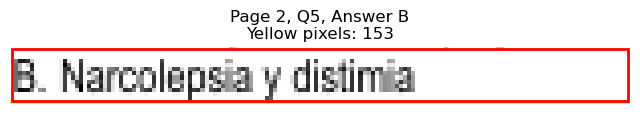

Page 2, Q5 - C: Detected box: x0=56.6, y0=392.3, x1=288.0, y1=405.0
Page 2, Q5, C: Yellow pixels: 2785
Page 2, Q5, C: Total non-white pixels: 3679
Page 2, Q5, C: Yellow percentage: 75.7%


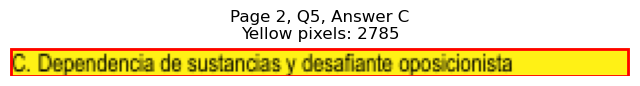

Page 2, Q5 - D: Detected box: x0=56.6, y0=404.9, x1=242.8, y1=417.6
Page 2, Q5, D: Yellow pixels: 231
Page 2, Q5, D: Total non-white pixels: 1167
Page 2, Q5, D: Yellow percentage: 19.8%


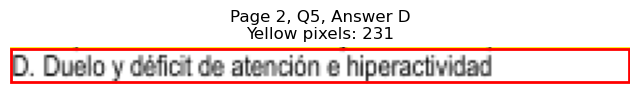


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)
Page 2, Q6 - A: Detected box: x0=56.6, y0=468.1, x1=140.5, y1=480.7
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 410
Page 2, Q6, A: Yellow percentage: 0.0%


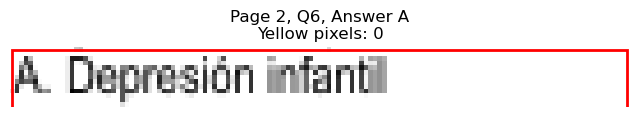

Page 2, Q6 - B: Detected box: x0=56.6, y0=480.8, x1=145.1, y1=493.4
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 411
Page 2, Q6, B: Yellow percentage: 0.0%


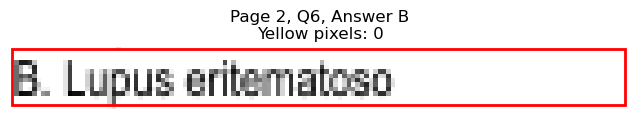

Page 2, Q6 - C: Detected box: x0=315.4, y0=468.1, x1=432.4, y1=480.7
Page 2, Q6, C: Yellow pixels: 1746
Page 2, Q6, C: Total non-white pixels: 2184
Page 2, Q6, C: Yellow percentage: 79.9%


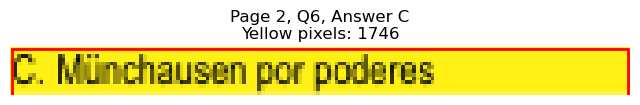

Page 2, Q6 - D: Detected box: x0=315.4, y0=480.8, x1=403.3, y1=493.4
Page 2, Q6, D: Yellow pixels: 139
Page 2, Q6, D: Total non-white pixels: 573
Page 2, Q6, D: Yellow percentage: 24.3%


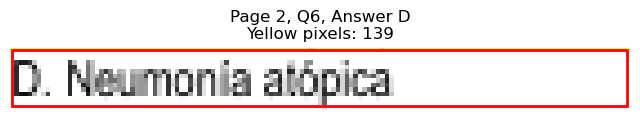


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)
Page 2, Q7 - A: Detected box: x0=56.6, y0=518.6, x1=151.1, y1=531.2
Page 2, Q7, A: Yellow pixels: 146
Page 2, Q7, A: Total non-white pixels: 600
Page 2, Q7, A: Yellow percentage: 24.3%


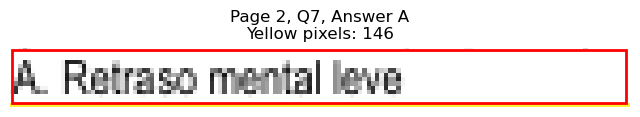

Page 2, Q7 - B: Detected box: x0=56.6, y0=531.2, x1=138.0, y1=543.8
Page 2, Q7, B: Yellow pixels: 1440
Page 2, Q7, B: Total non-white pixels: 1729
Page 2, Q7, B: Yellow percentage: 83.3%


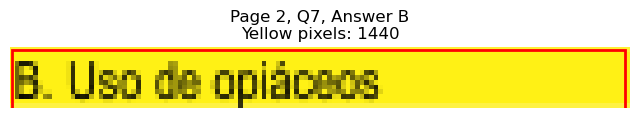

Page 2, Q7 - C: Detected box: x0=315.4, y0=518.6, x1=431.3, y1=531.2
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 567
Page 2, Q7, C: Yellow percentage: 0.0%


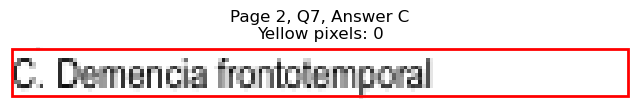

Page 2, Q7 - D: Detected box: x0=315.4, y0=531.2, x1=374.7, y1=543.8
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 261
Page 2, Q7, D: Yellow percentage: 0.0%


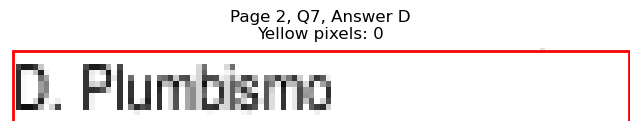


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)
Page 2, Q8 - A: Detected box: x0=56.6, y0=569.1, x1=143.1, y1=581.7
Page 2, Q8, A: Yellow pixels: 1
Page 2, Q8, A: Total non-white pixels: 532
Page 2, Q8, A: Yellow percentage: 0.2%


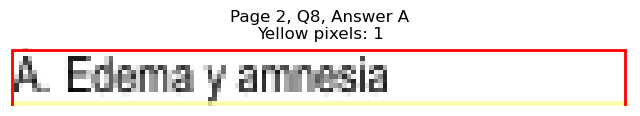

Page 2, Q8 - B: Detected box: x0=56.6, y0=581.7, x1=180.1, y1=594.3
Page 2, Q8, B: Yellow pixels: 1617
Page 2, Q8, B: Total non-white pixels: 2450
Page 2, Q8, B: Yellow percentage: 66.0%


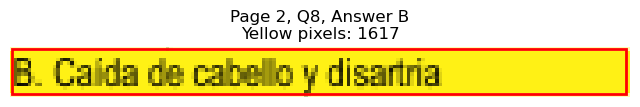

Page 2, Q8 - C: Detected box: x0=315.4, y0=569.1, x1=430.4, y1=581.7
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 535
Page 2, Q8, C: Yellow percentage: 0.0%


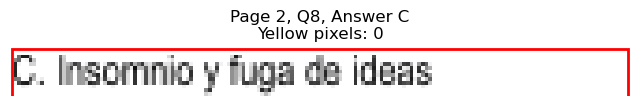

Page 2, Q8 - D: Detected box: x0=315.4, y0=581.7, x1=441.9, y1=594.3
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 649
Page 2, Q8, D: Yellow percentage: 0.0%


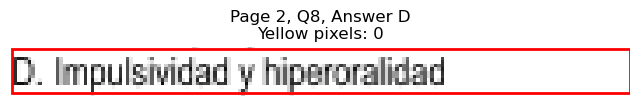


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)
Page 2, Q9 - A: Detected box: x0=56.6, y0=632.2, x1=125.4, y1=644.9
Page 2, Q9, A: Yellow pixels: 1295
Page 2, Q9, A: Total non-white pixels: 1560
Page 2, Q9, A: Yellow percentage: 83.0%


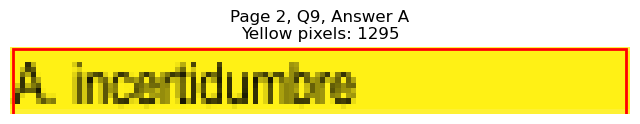

Page 2, Q9 - B: Detected box: x0=56.6, y0=644.8, x1=107.4, y1=657.5
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 242
Page 2, Q9, B: Yellow percentage: 0.0%


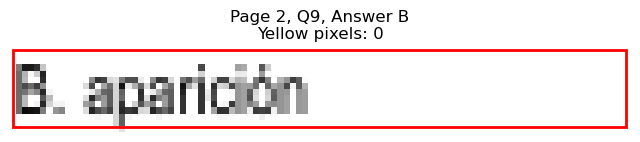

Page 2, Q9 - C: Detected box: x0=315.4, y0=632.2, x1=369.2, y1=644.9
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 256
Page 2, Q9, C: Yellow percentage: 0.0%


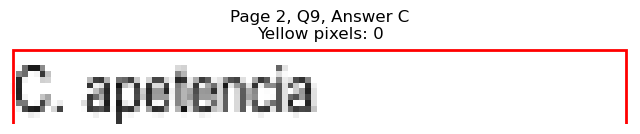

Page 2, Q9 - D: Detected box: x0=315.4, y0=644.8, x1=367.6, y1=657.5
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 236
Page 2, Q9, D: Yellow percentage: 0.0%


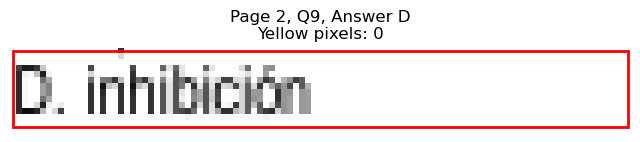


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)
Page 2, Q10 - A: Detected box: x0=56.6, y0=682.6, x1=116.4, y1=695.3
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 282
Page 2, Q10, A: Yellow percentage: 0.0%


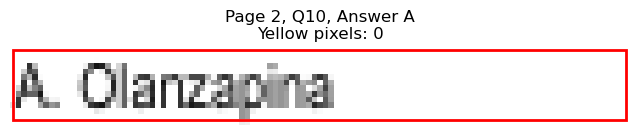

Page 2, Q10 - B: Detected box: x0=56.6, y0=695.4, x1=168.6, y1=708.0
Page 2, Q10, B: Yellow pixels: 1685
Page 2, Q10, B: Total non-white pixels: 2124
Page 2, Q10, B: Yellow percentage: 79.3%


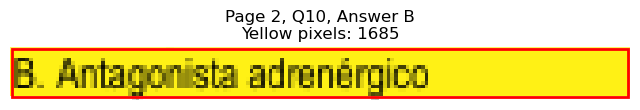

Page 2, Q10 - C: Detected box: x0=315.4, y0=682.6, x1=382.3, y1=695.3
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 327
Page 2, Q10, C: Yellow percentage: 0.0%


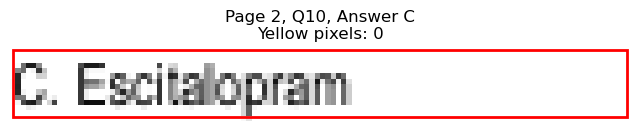

Page 2, Q10 - D: Detected box: x0=315.4, y0=695.4, x1=368.7, y1=708.0
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 237
Page 2, Q10, D: Yellow percentage: 0.0%


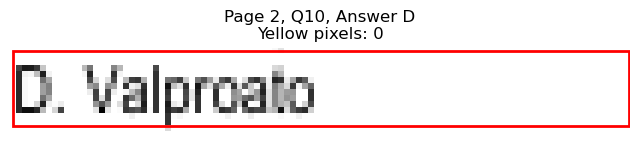


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)
Page 2, Q11 - A: Detected box: x0=56.6, y0=733.2, x1=109.5, y1=745.8
Page 2, Q11, A: Yellow pixels: 1139
Page 2, Q11, A: Total non-white pixels: 1352
Page 2, Q11, A: Yellow percentage: 84.2%


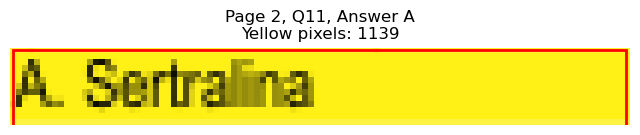

Page 2, Q11 - B: Detected box: x0=56.6, y0=745.8, x1=126.5, y1=758.4
Page 2, Q11, B: Yellow pixels: 121
Page 2, Q11, B: Total non-white pixels: 443
Page 2, Q11, B: Yellow percentage: 27.3%


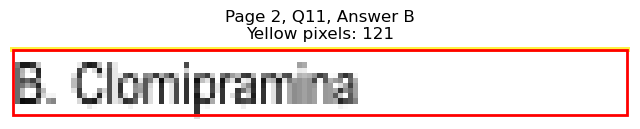

Page 2, Q11 - C: Detected box: x0=315.4, y0=733.2, x1=373.1, y1=745.8
Page 2, Q11, C: Yellow pixels: 0
Page 2, Q11, C: Total non-white pixels: 263
Page 2, Q11, C: Yellow percentage: 0.0%


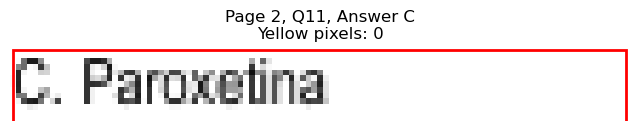

Page 2, Q11 - D: Detected box: x0=315.4, y0=745.8, x1=373.7, y1=758.4
Page 2, Q11, D: Yellow pixels: 0
Page 2, Q11, D: Total non-white pixels: 291
Page 2, Q11, D: Yellow percentage: 0.0%


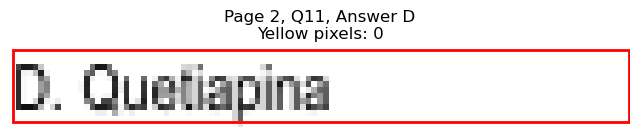


Page 2, Q11 - Selected Answer: A (based on yellow pixel count)

Page 3: Found 8 questions
Page 3, Q1 - A: Detected box: x0=56.6, y0=127.2, x1=145.0, y1=139.9
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 411
Page 3, Q1, A: Yellow percentage: 0.0%


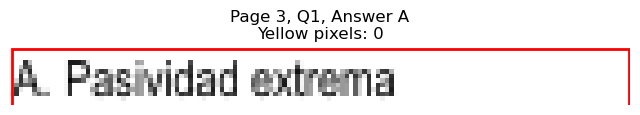

Page 3, Q1 - B: Detected box: x0=56.6, y0=139.9, x1=176.2, y1=152.6
Page 3, Q1, B: Yellow pixels: 1762
Page 3, Q1, B: Total non-white pixels: 2394
Page 3, Q1, B: Yellow percentage: 73.6%


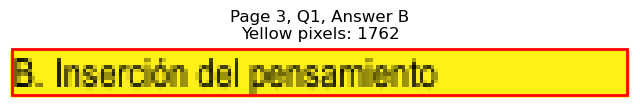

Page 3, Q1 - C: Detected box: x0=315.4, y0=127.2, x1=395.2, y1=139.9
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 387
Page 3, Q1, C: Yellow percentage: 0.0%


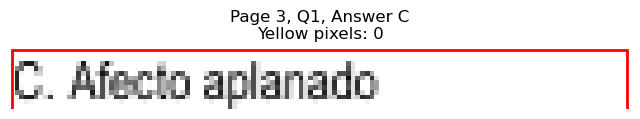

Page 3, Q1 - D: Detected box: x0=315.4, y0=139.9, x1=396.8, y1=152.6
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 396
Page 3, Q1, D: Yellow percentage: 0.0%


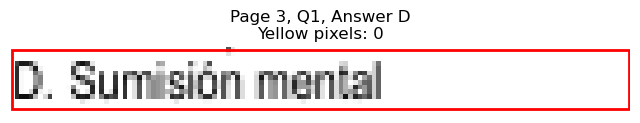


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)
Page 3, Q2 - A: Detected box: x0=56.6, y0=228.2, x1=154.1, y1=240.9
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 490
Page 3, Q2, A: Yellow percentage: 0.0%


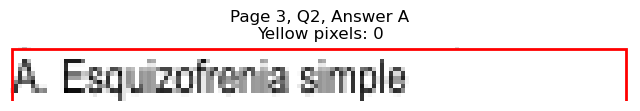

Page 3, Q2 - B: Detected box: x0=56.6, y0=240.8, x1=142.6, y1=253.5
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 431
Page 3, Q2, B: Yellow percentage: 0.0%


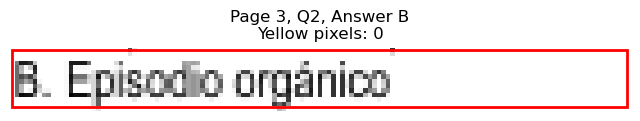

Page 3, Q2 - C: Detected box: x0=315.4, y0=228.2, x1=407.3, y1=240.9
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 578
Page 3, Q2, C: Yellow percentage: 0.0%


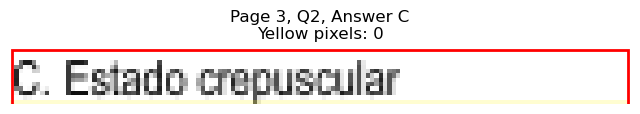

Page 3, Q2 - D: Detected box: x0=315.4, y0=240.8, x1=391.3, y1=253.5
Page 3, Q2, D: Yellow pixels: 1359
Page 3, Q2, D: Total non-white pixels: 1778
Page 3, Q2, D: Yellow percentage: 76.4%


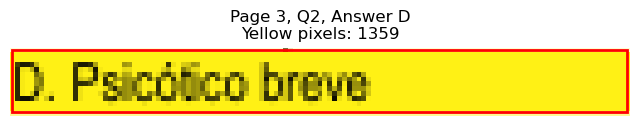


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)
Page 3, Q3 - A: Detected box: x0=56.6, y0=278.8, x1=125.5, y1=291.4
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 351
Page 3, Q3, A: Yellow percentage: 0.0%


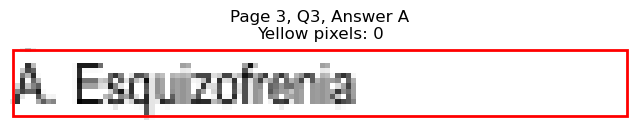

Page 3, Q3 - B: Detected box: x0=56.6, y0=291.4, x1=151.6, y1=304.0
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 453
Page 3, Q3, B: Yellow percentage: 0.0%


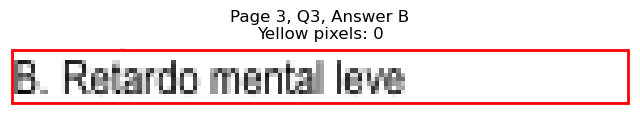

Page 3, Q3 - C: Detected box: x0=315.4, y0=278.8, x1=404.3, y1=291.4
Page 3, Q3, C: Yellow pixels: 1492
Page 3, Q3, C: Total non-white pixels: 1960
Page 3, Q3, C: Yellow percentage: 76.1%


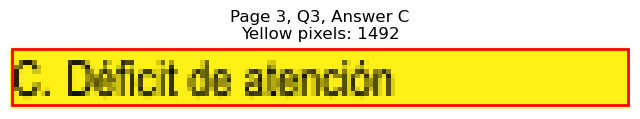

Page 3, Q3 - D: Detected box: x0=315.4, y0=291.4, x1=413.3, y1=304.0
Page 3, Q3, D: Yellow pixels: 149
Page 3, Q3, D: Total non-white pixels: 623
Page 3, Q3, D: Yellow percentage: 23.9%


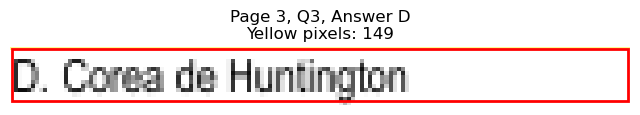


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)
Page 3, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=144.0, y1=354.6
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 430
Page 3, Q4, A: Yellow percentage: 0.0%


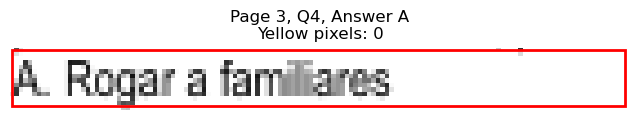

Page 3, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=184.1, y1=367.2
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 597
Page 3, Q4, B: Yellow percentage: 0.0%


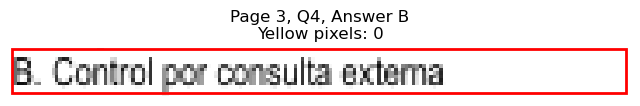

Page 3, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=424.4, y1=354.6
Page 3, Q4, C: Yellow pixels: 160
Page 3, Q4, C: Total non-white pixels: 678
Page 3, Q4, C: Yellow percentage: 23.6%


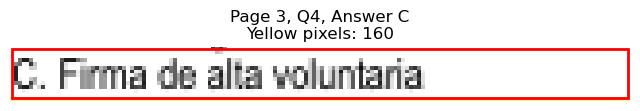

Page 3, Q4 - D: Detected box: x0=315.4, y0=354.5, x1=390.8, y1=367.2
Page 3, Q4, D: Yellow pixels: 1345
Page 3, Q4, D: Total non-white pixels: 1764
Page 3, Q4, D: Yellow percentage: 76.2%


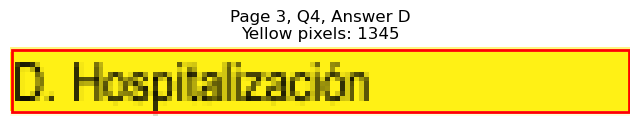


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)
Page 3, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=110.9, y1=430.3
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 244
Page 3, Q5, A: Yellow percentage: 0.0%


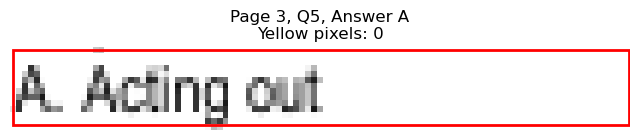

Page 3, Q5 - B: Detected box: x0=56.6, y0=430.2, x1=103.9, y1=442.9
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 228
Page 3, Q5, B: Yellow percentage: 0.0%


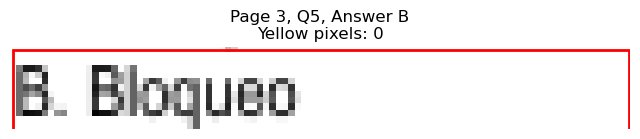

Page 3, Q5 - C: Detected box: x0=315.4, y0=417.6, x1=350.7, y1=430.3
Page 3, Q5, C: Yellow pixels: 914
Page 3, Q5, C: Total non-white pixels: 1204
Page 3, Q5, C: Yellow percentage: 75.9%


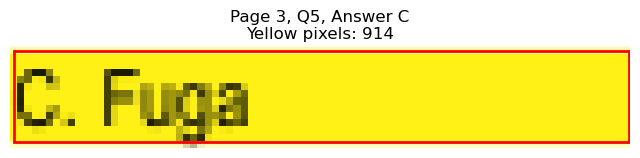

Page 3, Q5 - D: Detected box: x0=315.4, y0=430.2, x1=366.7, y1=442.9
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 355
Page 3, Q5, D: Yellow percentage: 0.0%


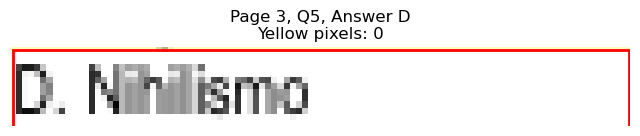


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)
Page 3, Q6 - A: Detected box: x0=56.6, y0=480.8, x1=106.0, y1=493.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 221
Page 3, Q6, A: Yellow percentage: 0.0%


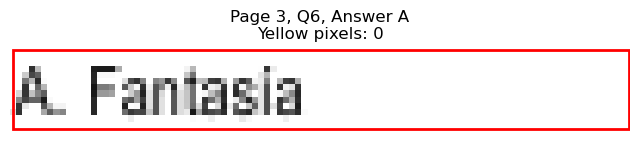

Page 3, Q6 - B: Detected box: x0=56.6, y0=493.4, x1=97.9, y1=506.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 174
Page 3, Q6, B: Yellow percentage: 0.0%


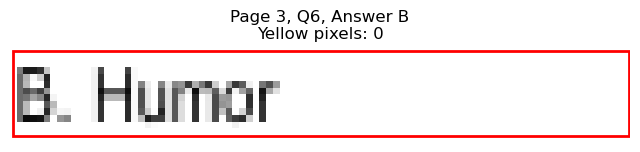

Page 3, Q6 - C: Detected box: x0=315.4, y0=480.8, x1=367.6, y1=493.4
Page 3, Q6, C: Yellow pixels: 103
Page 3, Q6, C: Total non-white pixels: 337
Page 3, Q6, C: Yellow percentage: 30.6%


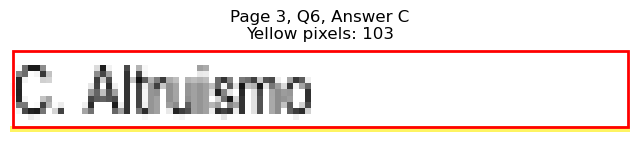

Page 3, Q6 - D: Detected box: x0=315.4, y0=493.4, x1=376.1, y1=506.0
Page 3, Q6, D: Yellow pixels: 1237
Page 3, Q6, D: Total non-white pixels: 1456
Page 3, Q6, D: Yellow percentage: 85.0%


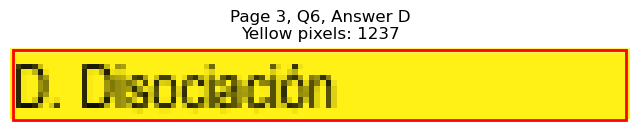


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)
Page 3, Q7 - A: Detected box: x0=56.6, y0=581.7, x1=109.5, y1=594.3
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 256
Page 3, Q7, A: Yellow percentage: 0.0%


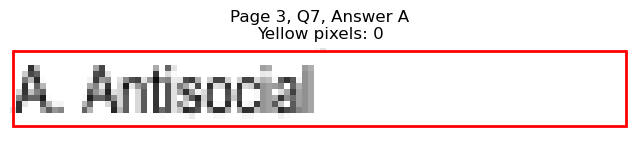

Page 3, Q7 - B: Detected box: x0=56.6, y0=594.3, x1=112.9, y1=606.9
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 287
Page 3, Q7, B: Yellow percentage: 0.0%


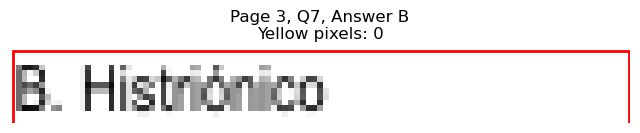

Page 3, Q7 - C: Detected box: x0=315.4, y0=581.7, x1=367.6, y1=594.3
Page 3, Q7, C: Yellow pixels: 103
Page 3, Q7, C: Total non-white pixels: 336
Page 3, Q7, C: Yellow percentage: 30.7%


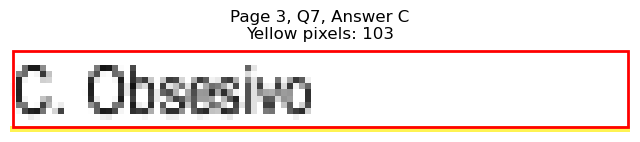

Page 3, Q7 - D: Detected box: x0=315.4, y0=594.3, x1=369.7, y1=606.9
Page 3, Q7, D: Yellow pixels: 1152
Page 3, Q7, D: Total non-white pixels: 1365
Page 3, Q7, D: Yellow percentage: 84.4%


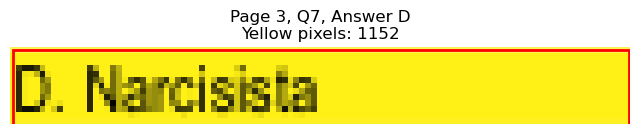


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)
Page 3, Q8 - A: Detected box: x0=56.6, y0=657.4, x1=102.9, y1=670.1
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 208
Page 3, Q8, A: Yellow percentage: 0.0%


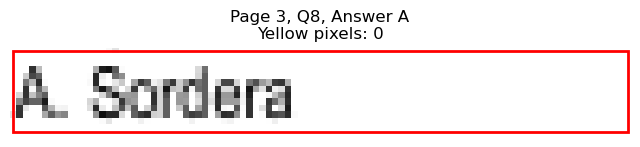

Page 3, Q8 - B: Detected box: x0=56.6, y0=670.0, x1=145.1, y1=682.7
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 436
Page 3, Q8, B: Yellow percentage: 0.0%


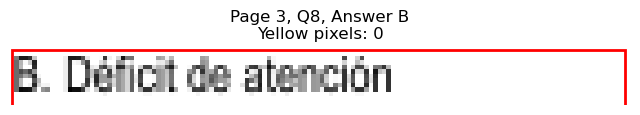

Page 3, Q8 - C: Detected box: x0=315.4, y0=657.4, x1=409.7, y1=670.1
Page 3, Q8, C: Yellow pixels: 1519
Page 3, Q8, C: Total non-white pixels: 2030
Page 3, Q8, C: Yellow percentage: 74.8%


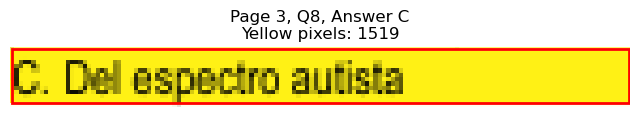

Page 3, Q8 - D: Detected box: x0=315.4, y0=670.0, x1=382.3, y1=682.7
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 474
Page 3, Q8, D: Yellow percentage: 0.0%


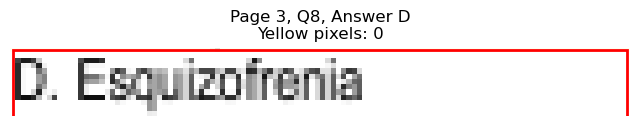


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)

Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=139.9, x1=117.5, y1=152.6
Page 4, Q1, A: Yellow pixels: 1235
Page 4, Q1, A: Total non-white pixels: 1568
Page 4, Q1, A: Yellow percentage: 78.8%


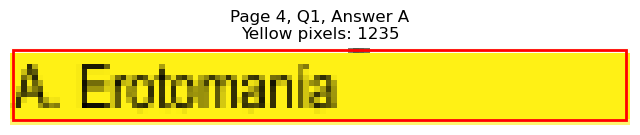

Page 4, Q1 - B: Detected box: x0=56.6, y0=152.5, x1=115.5, y1=165.2
Page 4, Q1, B: Yellow pixels: 110
Page 4, Q1, B: Total non-white pixels: 402
Page 4, Q1, B: Yellow percentage: 27.4%


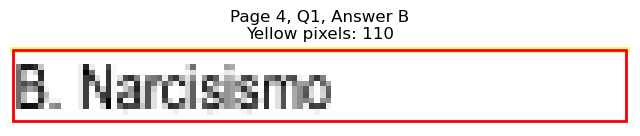

Page 4, Q1 - C: Detected box: x0=315.4, y0=139.9, x1=360.7, y1=152.6
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 217
Page 4, Q1, C: Yellow percentage: 0.0%


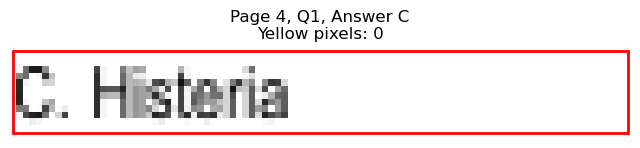

Page 4, Q1 - D: Detected box: x0=315.4, y0=152.5, x1=367.6, y1=165.2
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 239
Page 4, Q1, D: Yellow percentage: 0.0%


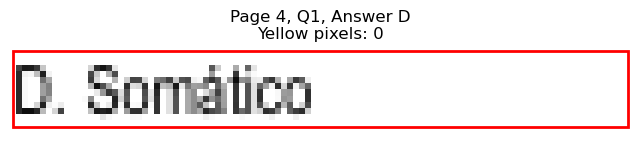


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)
Page 4, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=129.0, y1=203.0
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 337
Page 4, Q2, A: Yellow percentage: 0.0%


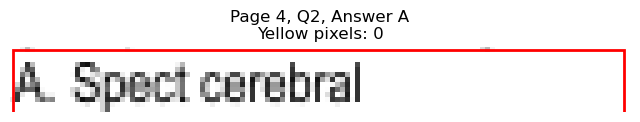

Page 4, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=219.8, y1=215.6
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 795
Page 4, Q2, B: Yellow percentage: 0.0%


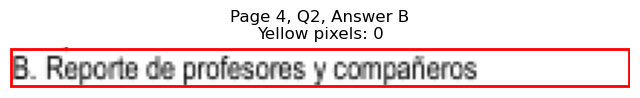

Page 4, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=415.3, y1=203.0
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 631
Page 4, Q2, C: Yellow percentage: 0.0%


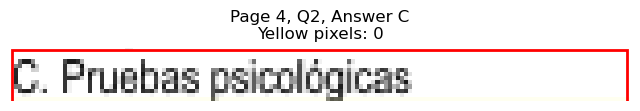

Page 4, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=540.7, y1=215.6
Page 4, Q2, D: Yellow pixels: 2093
Page 4, Q2, D: Total non-white pixels: 3163
Page 4, Q2, D: Yellow percentage: 66.2%


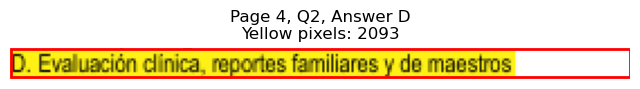


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)
Page 4, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=118.5, y1=278.7
Page 4, Q3, A: Yellow pixels: 1246
Page 4, Q3, A: Total non-white pixels: 1469
Page 4, Q3, A: Yellow percentage: 84.8%


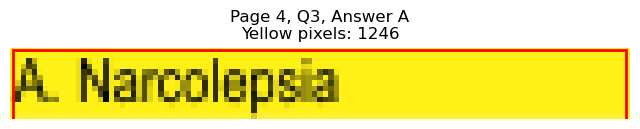

Page 4, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=107.4, y1=291.4
Page 4, Q3, B: Yellow pixels: 102
Page 4, Q3, B: Total non-white pixels: 368
Page 4, Q3, B: Yellow percentage: 27.7%


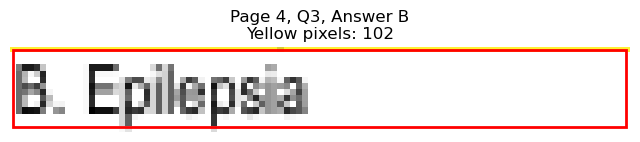

Page 4, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=362.1, y1=278.7
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 222
Page 4, Q3, C: Yellow percentage: 0.0%


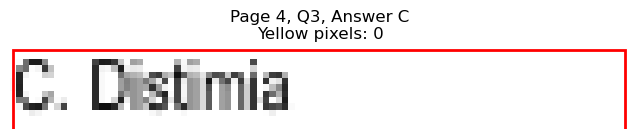

Page 4, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=375.7, y1=291.4
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 279
Page 4, Q3, D: Yellow percentage: 0.0%


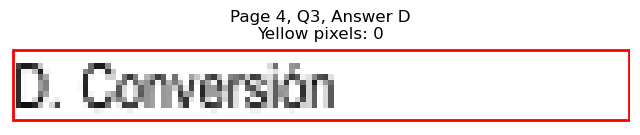


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)
Page 4, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=111.4, y1=341.8
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 251
Page 4, Q4, A: Yellow percentage: 0.0%


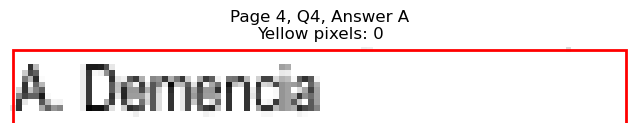

Page 4, Q4 - B: Detected box: x0=56.6, y0=341.9, x1=105.9, y1=354.6
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 240
Page 4, Q4, B: Yellow percentage: 0.0%


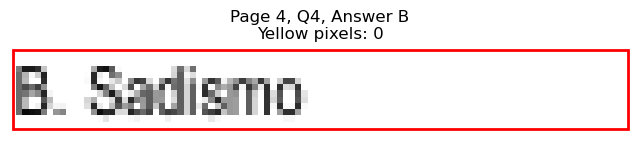

Page 4, Q4 - C: Detected box: x0=315.4, y0=329.2, x1=377.7, y1=341.8
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 287
Page 4, Q4, C: Yellow percentage: 0.0%


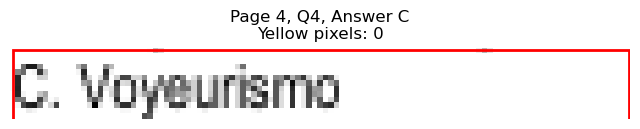

Page 4, Q4 - D: Detected box: x0=315.4, y0=341.9, x1=390.2, y1=354.6
Page 4, Q4, D: Yellow pixels: 1355
Page 4, Q4, D: Total non-white pixels: 1764
Page 4, Q4, D: Yellow percentage: 76.8%


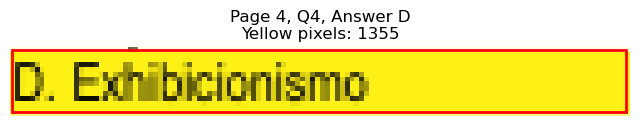


Page 4, Q4 - Selected Answer: D (based on yellow pixel count)
Page 4, Q5 - A: Detected box: x0=56.6, y0=430.2, x1=110.9, y1=442.9
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 252
Page 4, Q5, A: Yellow percentage: 0.0%


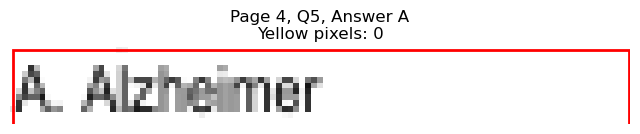

Page 4, Q5 - B: Detected box: x0=56.6, y0=442.8, x1=141.0, y1=455.5
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 386
Page 4, Q5, B: Yellow percentage: 0.0%


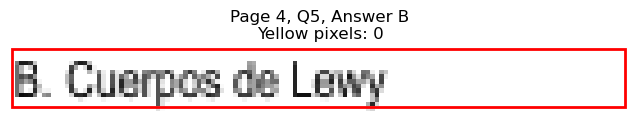

Page 4, Q5 - C: Detected box: x0=315.4, y0=430.2, x1=391.3, y1=442.9
Page 4, Q5, C: Yellow pixels: 1371
Page 4, Q5, C: Total non-white pixels: 1651
Page 4, Q5, C: Yellow percentage: 83.0%


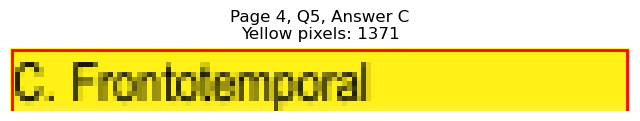

Page 4, Q5 - D: Detected box: x0=315.4, y0=442.8, x1=389.2, y1=455.5
Page 4, Q5, D: Yellow pixels: 124
Page 4, Q5, D: Total non-white pixels: 474
Page 4, Q5, D: Yellow percentage: 26.2%


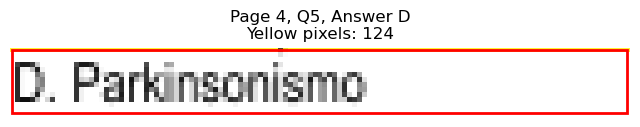


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)
Page 4, Q6 - A: Detected box: x0=56.6, y0=493.4, x1=99.4, y1=506.0
Page 4, Q6, A: Yellow pixels: 94
Page 4, Q6, A: Total non-white pixels: 379
Page 4, Q6, A: Yellow percentage: 24.8%


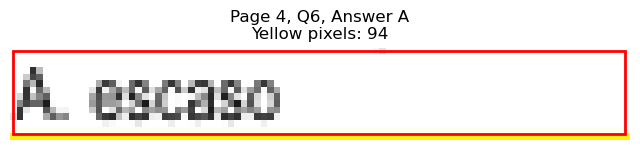

Page 4, Q6 - B: Detected box: x0=56.6, y0=506.0, x1=95.9, y1=518.6
Page 4, Q6, B: Yellow pixels: 1039
Page 4, Q6, B: Total non-white pixels: 1260
Page 4, Q6, B: Yellow percentage: 82.5%


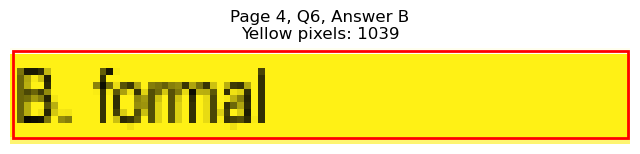

Page 4, Q6 - C: Detected box: x0=315.4, y0=493.4, x1=368.7, y1=506.0
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 253
Page 4, Q6, C: Yellow percentage: 0.0%


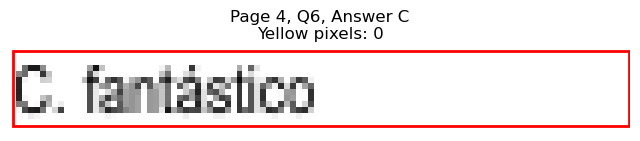

Page 4, Q6 - D: Detected box: x0=315.4, y0=506.0, x1=355.6, y1=518.6
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 185
Page 4, Q6, D: Yellow percentage: 0.0%


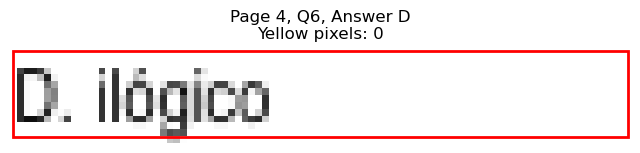


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)
Page 4, Q7 - A: Detected box: x0=56.6, y0=556.5, x1=116.4, y1=569.1
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 275
Page 4, Q7, A: Yellow percentage: 0.0%


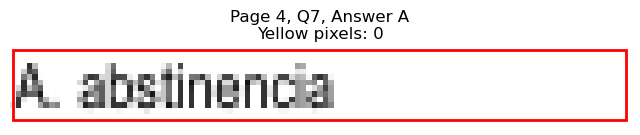

Page 4, Q7 - B: Detected box: x0=56.6, y0=569.1, x1=100.9, y1=581.7
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 203
Page 4, Q7, B: Yellow percentage: 0.0%


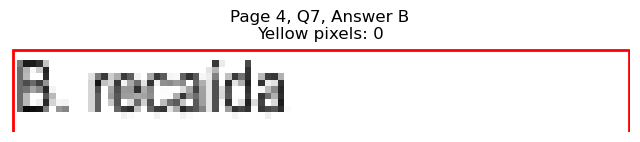

Page 4, Q7 - C: Detected box: x0=315.4, y0=556.5, x1=356.1, y1=569.1
Page 4, Q7, C: Yellow pixels: 1076
Page 4, Q7, C: Total non-white pixels: 1288
Page 4, Q7, C: Yellow percentage: 83.5%


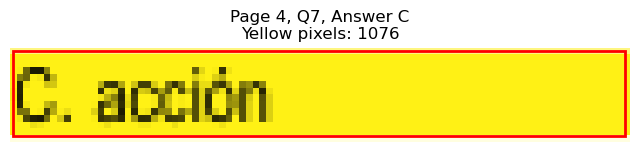

Page 4, Q7 - D: Detected box: x0=315.4, y0=569.1, x1=369.2, y1=581.7
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 369
Page 4, Q7, D: Yellow percentage: 0.0%


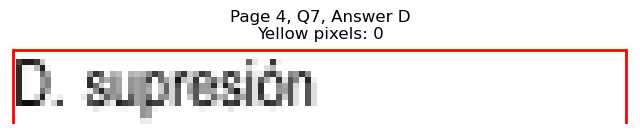


Page 4, Q7 - Selected Answer: C (based on yellow pixel count)
Page 4, Q8 - A: Detected box: x0=56.6, y0=606.9, x1=118.0, y1=619.5
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 278
Page 4, Q8, A: Yellow percentage: 0.0%


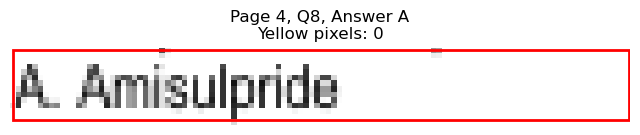

Page 4, Q8 - B: Detected box: x0=56.6, y0=619.6, x1=116.5, y1=632.3
Page 4, Q8, B: Yellow pixels: 1088
Page 4, Q8, B: Total non-white pixels: 1554
Page 4, Q8, B: Yellow percentage: 70.0%


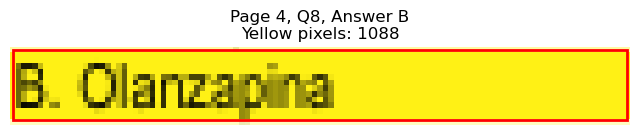

Page 4, Q8 - C: Detected box: x0=315.4, y0=606.9, x1=388.7, y1=619.5
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 356
Page 4, Q8, C: Yellow percentage: 0.0%


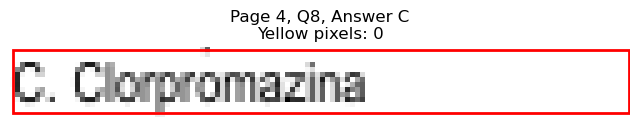

Page 4, Q8 - D: Detected box: x0=315.4, y0=619.6, x1=374.2, y1=632.3
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 285
Page 4, Q8, D: Yellow percentage: 0.0%


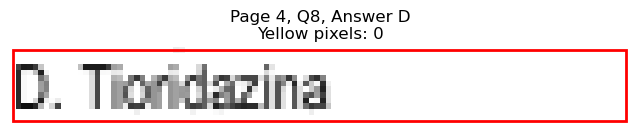


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)
Page 4, Q9 - A: Detected box: x0=56.6, y0=695.4, x1=166.6, y1=708.0
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 531
Page 4, Q9, A: Yellow percentage: 0.0%


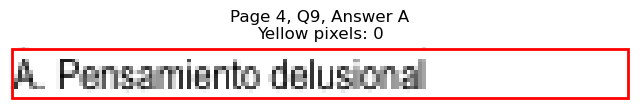

Page 4, Q9 - B: Detected box: x0=56.6, y0=708.0, x1=157.1, y1=720.6
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 497
Page 4, Q9, B: Yellow percentage: 0.0%


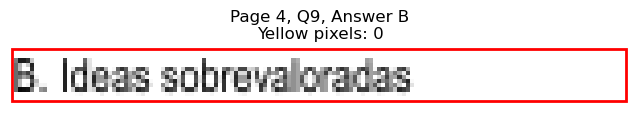

Page 4, Q9 - C: Detected box: x0=315.4, y0=695.4, x1=421.9, y1=708.0
Page 4, Q9, C: Yellow pixels: 1634
Page 4, Q9, C: Total non-white pixels: 2043
Page 4, Q9, C: Yellow percentage: 80.0%


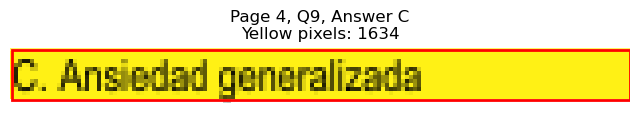

Page 4, Q9 - D: Detected box: x0=315.4, y0=708.0, x1=393.8, y1=720.6
Page 4, Q9, D: Yellow pixels: 125
Page 4, Q9, D: Total non-white pixels: 491
Page 4, Q9, D: Yellow percentage: 25.5%


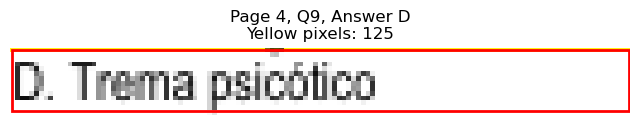


Page 4, Q9 - Selected Answer: C (based on yellow pixel count)

Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=127.2, x1=147.0, y1=139.9
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 452
Page 5, Q1, A: Yellow percentage: 0.0%


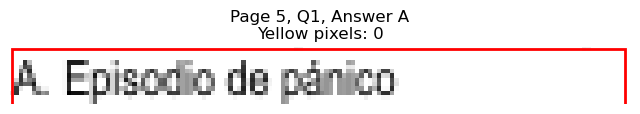

Page 5, Q1 - B: Detected box: x0=56.6, y0=139.9, x1=138.0, y1=152.6
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 388
Page 5, Q1, B: Yellow percentage: 0.0%


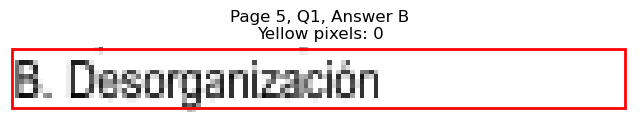

Page 5, Q1 - C: Detected box: x0=315.4, y0=127.2, x1=429.9, y1=139.9
Page 5, Q1, C: Yellow pixels: 1706
Page 5, Q1, C: Total non-white pixels: 2145
Page 5, Q1, C: Yellow percentage: 79.5%


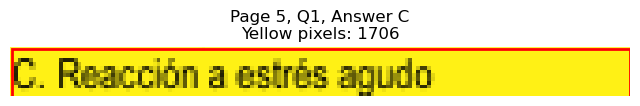

Page 5, Q1 - D: Detected box: x0=315.4, y0=139.9, x1=394.7, y1=152.6
Page 5, Q1, D: Yellow pixels: 126
Page 5, Q1, D: Total non-white pixels: 526
Page 5, Q1, D: Yellow percentage: 24.0%


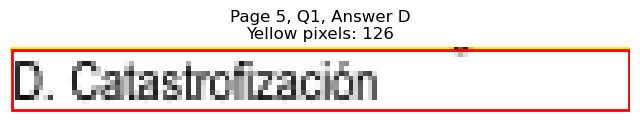


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)
Page 5, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=135.0, y1=203.0
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 367
Page 5, Q2, A: Yellow percentage: 0.0%


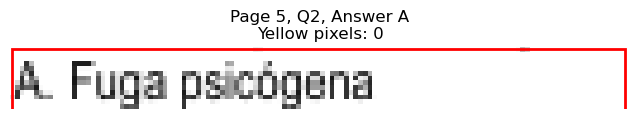

Page 5, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=110.9, y1=215.6
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 264
Page 5, Q2, B: Yellow percentage: 0.0%


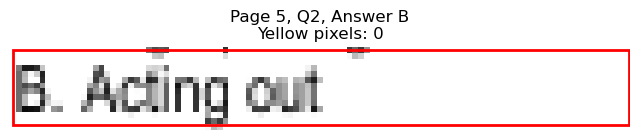

Page 5, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=406.7, y1=203.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 563
Page 5, Q2, C: Yellow percentage: 0.0%


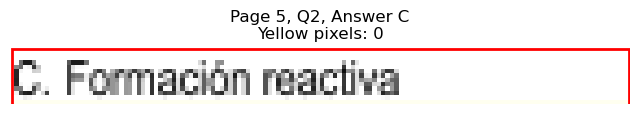

Page 5, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=409.7, y1=215.6
Page 5, Q2, D: Yellow pixels: 1532
Page 5, Q2, D: Total non-white pixels: 2030
Page 5, Q2, D: Yellow percentage: 75.5%


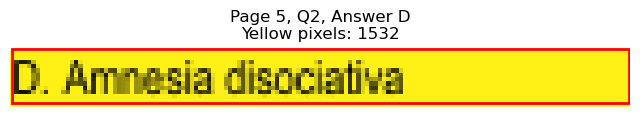


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)
Page 5, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=101.4, y1=266.1
Page 5, Q3, A: Yellow pixels: 96
Page 5, Q3, A: Total non-white pixels: 301
Page 5, Q3, A: Yellow percentage: 31.9%


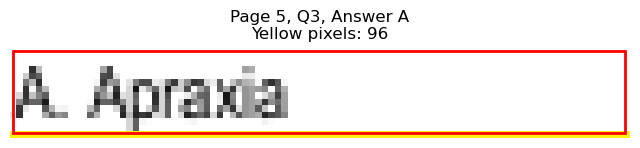

Page 5, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=110.9, y1=278.7
Page 5, Q3, B: Yellow pixels: 1157
Page 5, Q3, B: Total non-white pixels: 1365
Page 5, Q3, B: Yellow percentage: 84.8%


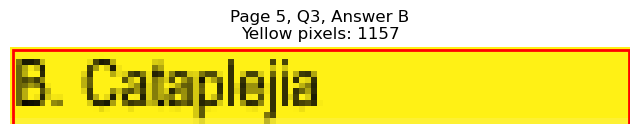

Page 5, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=356.1, y1=266.1
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 184
Page 5, Q3, C: Yellow percentage: 0.0%


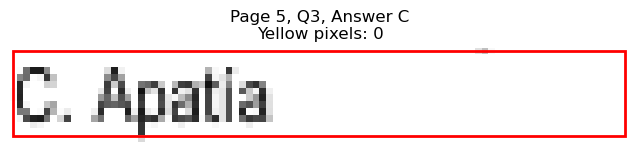

Page 5, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=405.8, y1=278.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 458
Page 5, Q3, D: Yellow percentage: 0.0%


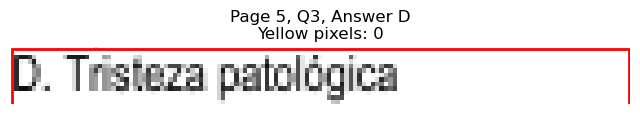


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)
Page 5, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=201.8, y1=329.2
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 686
Page 5, Q4, A: Yellow percentage: 0.0%


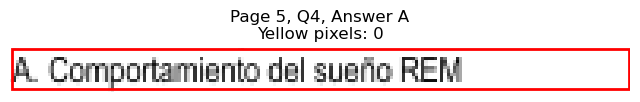

Page 5, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=133.0, y1=341.8
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 316
Page 5, Q4, B: Yellow percentage: 0.0%


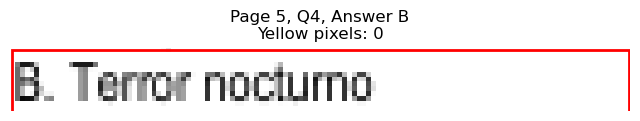

Page 5, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=377.7, y1=329.2
Page 5, Q4, C: Yellow pixels: 113
Page 5, Q4, C: Total non-white pixels: 413
Page 5, Q4, C: Yellow percentage: 27.4%


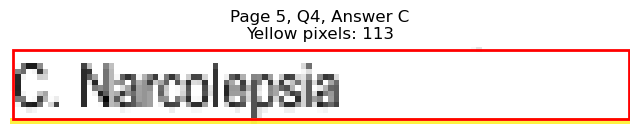

Page 5, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=371.2, y1=341.8
Page 5, Q4, D: Yellow pixels: 1170
Page 5, Q4, D: Total non-white pixels: 1391
Page 5, Q4, D: Yellow percentage: 84.1%


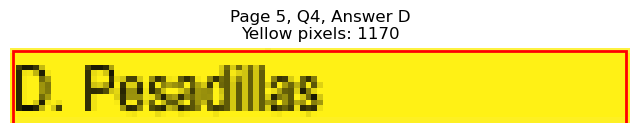


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)
Page 5, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=113.4, y1=430.3
Page 5, Q5, A: Yellow pixels: 1097
Page 5, Q5, A: Total non-white pixels: 1512
Page 5, Q5, A: Yellow percentage: 72.6%


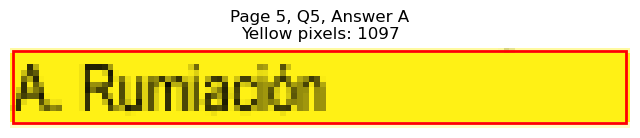

Page 5, Q5 - B: Detected box: x0=56.6, y0=430.2, x1=141.0, y1=442.9
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 568
Page 5, Q5, B: Yellow percentage: 0.0%


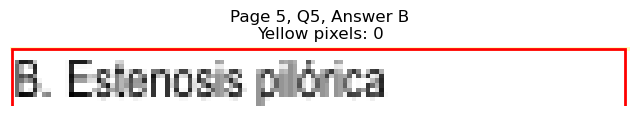

Page 5, Q5 - C: Detected box: x0=315.4, y0=417.6, x1=420.8, y1=430.3
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 492
Page 5, Q5, C: Yellow percentage: 0.0%


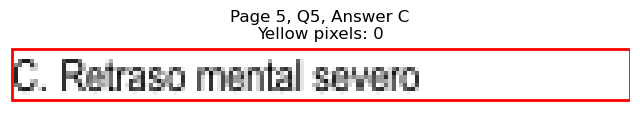

Page 5, Q5 - D: Detected box: x0=315.4, y0=430.2, x1=387.8, y1=442.9
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 351
Page 5, Q5, D: Yellow percentage: 0.0%


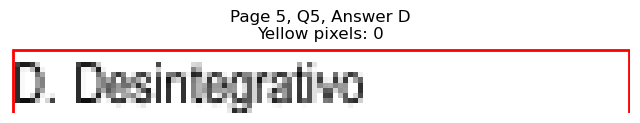


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)
Page 5, Q6 - A: Detected box: x0=56.6, y0=468.1, x1=111.5, y1=480.7
Page 5, Q6, A: Yellow pixels: 1180
Page 5, Q6, A: Total non-white pixels: 1378
Page 5, Q6, A: Yellow percentage: 85.6%


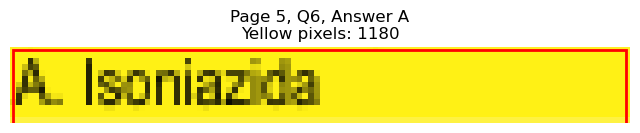

Page 5, Q6 - B: Detected box: x0=56.6, y0=480.8, x1=118.9, y1=493.4
Page 5, Q6, B: Yellow pixels: 113
Page 5, Q6, B: Total non-white pixels: 401
Page 5, Q6, B: Yellow percentage: 28.2%


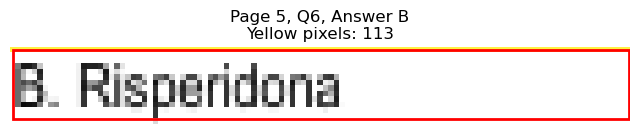

Page 5, Q6 - C: Detected box: x0=315.4, y0=468.1, x1=374.2, y1=480.7
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 264
Page 5, Q6, C: Yellow percentage: 0.0%


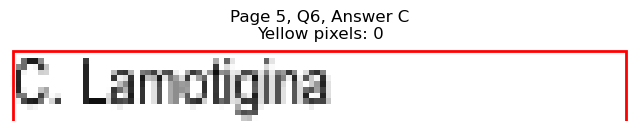

Page 5, Q6 - D: Detected box: x0=315.4, y0=480.8, x1=375.7, y1=493.4
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 285
Page 5, Q6, D: Yellow percentage: 0.0%


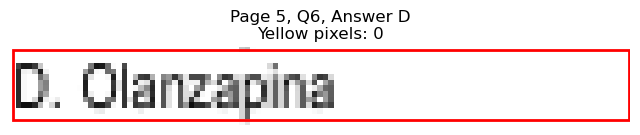


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)
Page 5, Q7 - A: Detected box: x0=56.6, y0=556.5, x1=111.4, y1=569.1
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 258
Page 5, Q7, A: Yellow percentage: 0.0%


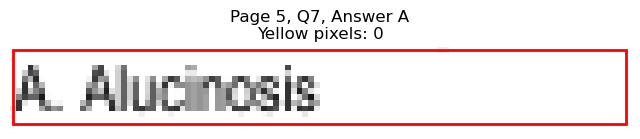

Page 5, Q7 - B: Detected box: x0=56.6, y0=569.1, x1=118.0, y1=581.7
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 317
Page 5, Q7, B: Yellow percentage: 0.0%


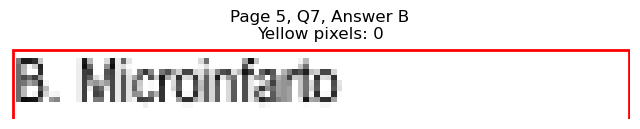

Page 5, Q7 - C: Detected box: x0=315.4, y0=556.5, x1=363.2, y1=569.1
Page 5, Q7, C: Yellow pixels: 1100
Page 5, Q7, C: Total non-white pixels: 1386
Page 5, Q7, C: Yellow percentage: 79.4%


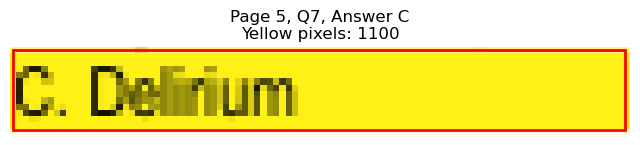

Page 5, Q7 - D: Detected box: x0=315.4, y0=569.1, x1=370.6, y1=581.7
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 354
Page 5, Q7, D: Yellow percentage: 0.0%


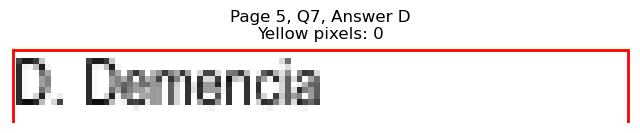


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)
Page 5, Q8 - A: Detected box: x0=56.6, y0=606.9, x1=158.5, y1=619.5
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 517
Page 5, Q8, A: Yellow percentage: 0.0%


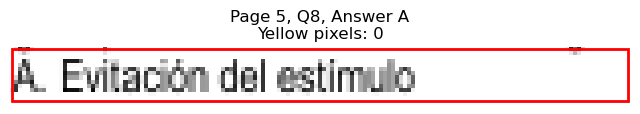

Page 5, Q8 - B: Detected box: x0=56.6, y0=619.6, x1=126.5, y1=632.3
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 319
Page 5, Q8, B: Yellow percentage: 0.0%


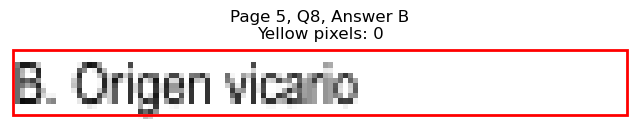

Page 5, Q8 - C: Detected box: x0=315.4, y0=606.9, x1=432.3, y1=619.5
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 580
Page 5, Q8, C: Yellow percentage: 0.0%


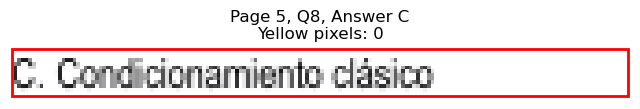

Page 5, Q8 - D: Detected box: x0=315.4, y0=619.6, x1=444.9, y1=632.3
Page 5, Q8, D: Yellow pixels: 1669
Page 5, Q8, D: Total non-white pixels: 2520
Page 5, Q8, D: Yellow percentage: 66.2%


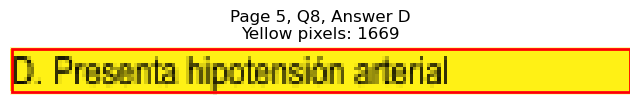


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)
Page 5, Q9 - A: Detected box: x0=56.6, y0=657.4, x1=95.9, y1=670.1
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 190
Page 5, Q9, A: Yellow percentage: 0.0%


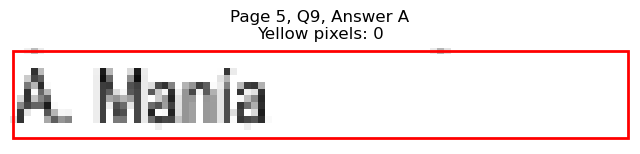

Page 5, Q9 - B: Detected box: x0=56.6, y0=670.0, x1=140.5, y1=682.7
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 403
Page 5, Q9, B: Yellow percentage: 0.0%


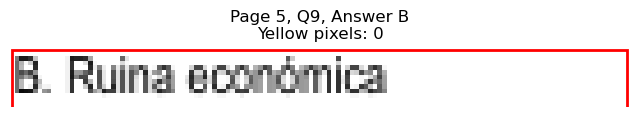

Page 5, Q9 - C: Detected box: x0=315.4, y0=657.4, x1=365.7, y1=670.1
Page 5, Q9, C: Yellow pixels: 101
Page 5, Q9, C: Total non-white pixels: 332
Page 5, Q9, C: Yellow percentage: 30.4%


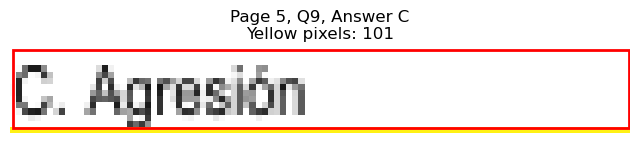

Page 5, Q9 - D: Detected box: x0=315.4, y0=670.0, x1=361.6, y1=682.7
Page 5, Q9, D: Yellow pixels: 1098
Page 5, Q9, D: Total non-white pixels: 1261
Page 5, Q9, D: Yellow percentage: 87.1%


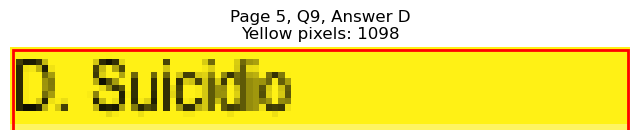


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)
Page 5, Q10 - A: Detected box: x0=56.6, y0=720.6, x1=109.9, y1=733.2
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 247
Page 5, Q10, A: Yellow percentage: 0.0%


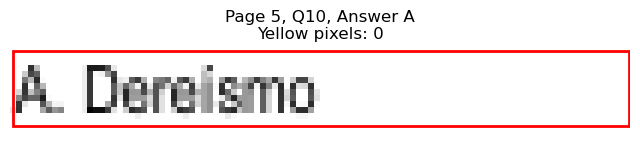

Page 5, Q10 - B: Detected box: x0=56.6, y0=733.2, x1=116.1, y1=745.8
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 284
Page 5, Q10, B: Yellow percentage: 0.0%


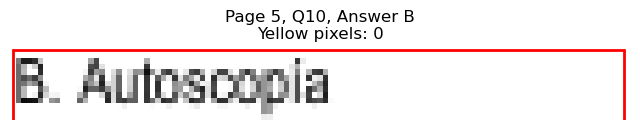

Page 5, Q10 - C: Detected box: x0=315.4, y0=720.6, x1=389.2, y1=733.2
Page 5, Q10, C: Yellow pixels: 1367
Page 5, Q10, C: Total non-white pixels: 1750
Page 5, Q10, C: Yellow percentage: 78.1%


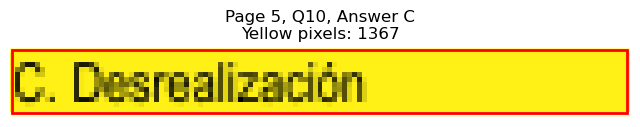

Page 5, Q10 - D: Detected box: x0=315.4, y0=733.2, x1=371.2, y1=745.8
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 365
Page 5, Q10, D: Yellow percentage: 0.0%


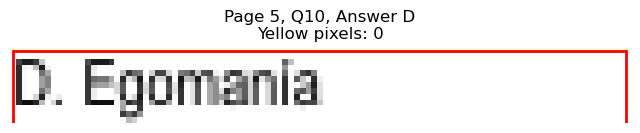


Page 5, Q10 - Selected Answer: C (based on yellow pixel count)

Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=363.2, y1=114.7
Page 6, Q1, A: Yellow pixels: 3444
Page 6, Q1, A: Total non-white pixels: 4654
Page 6, Q1, A: Yellow percentage: 74.0%


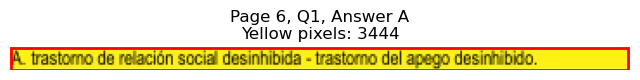

Page 6, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=363.2, y1=127.3
Page 6, Q1, B: Yellow pixels: 357
Page 6, Q1, B: Total non-white pixels: 1884
Page 6, Q1, B: Yellow percentage: 18.9%


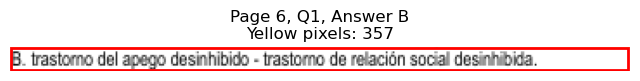

Page 6, Q1 - C: Detected box: x0=56.6, y0=127.2, x1=329.1, y1=139.9
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 1292
Page 6, Q1, C: Yellow percentage: 0.0%


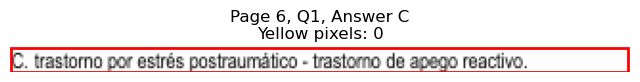

Page 6, Q1 - D: Detected box: x0=56.6, y0=139.9, x1=286.4, y1=152.6
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 1124
Page 6, Q1, D: Yellow percentage: 0.0%


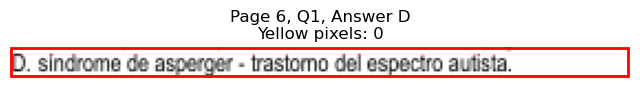


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)
Page 6, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=128.5, y1=203.0
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 316
Page 6, Q2, A: Yellow percentage: 0.0%


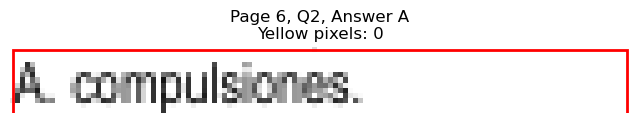

Page 6, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=107.4, y1=215.6
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 250
Page 6, Q2, B: Yellow percentage: 0.0%


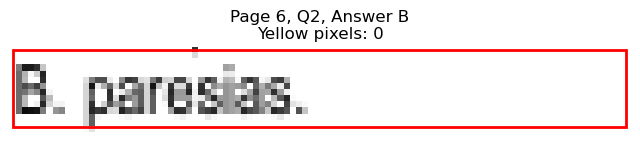

Page 6, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=363.7, y1=203.0
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 318
Page 6, Q2, C: Yellow percentage: 0.0%


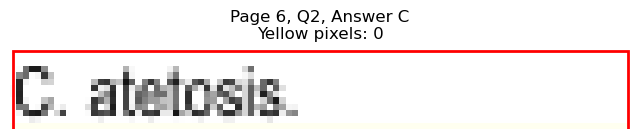

Page 6, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=408.3, y1=215.6
Page 6, Q2, D: Yellow pixels: 1541
Page 6, Q2, D: Total non-white pixels: 2016
Page 6, Q2, D: Yellow percentage: 76.4%


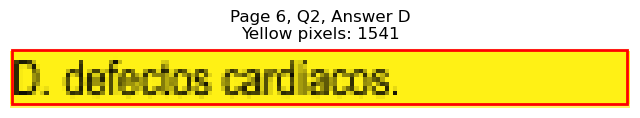


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)
Page 6, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=169.1, y1=278.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 529
Page 6, Q3, A: Yellow percentage: 0.0%


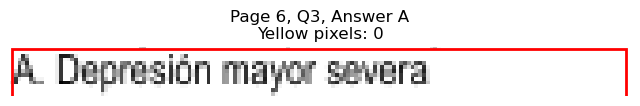

Page 6, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=135.5, y1=291.4
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 394
Page 6, Q3, B: Yellow percentage: 0.0%


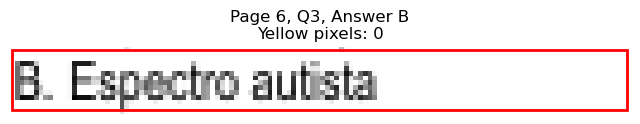

Page 6, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=427.9, y1=278.7
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 548
Page 6, Q3, C: Yellow percentage: 0.0%


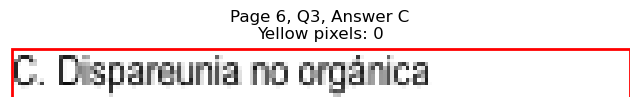

Page 6, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=421.9, y1=291.4
Page 6, Q3, D: Yellow pixels: 1675
Page 6, Q3, D: Total non-white pixels: 2198
Page 6, Q3, D: Yellow percentage: 76.2%


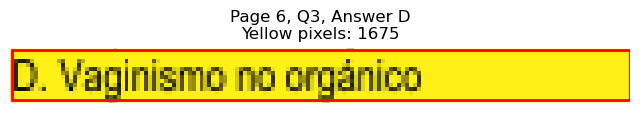


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)
Page 6, Q4 - A: Detected box: x0=56.6, y0=354.5, x1=115.0, y1=367.2
Page 6, Q4, A: Yellow pixels: 109
Page 6, Q4, A: Total non-white pixels: 390
Page 6, Q4, A: Yellow percentage: 27.9%


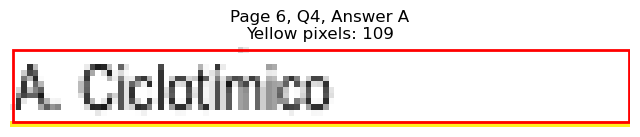

Page 6, Q4 - B: Detected box: x0=56.6, y0=367.1, x1=158.1, y1=379.8
Page 6, Q4, B: Yellow pixels: 1591
Page 6, Q4, B: Total non-white pixels: 1989
Page 6, Q4, B: Yellow percentage: 80.0%


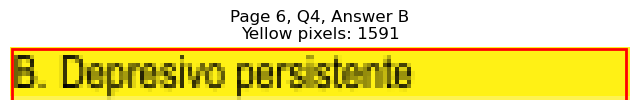

Page 6, Q4 - C: Detected box: x0=315.4, y0=354.5, x1=418.4, y1=367.2
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 519
Page 6, Q4, C: Yellow percentage: 0.0%


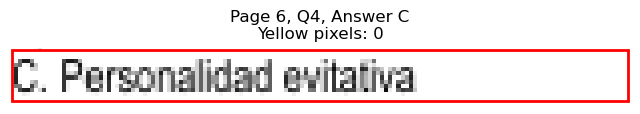

Page 6, Q4 - D: Detected box: x0=315.4, y0=367.1, x1=374.2, y1=379.8
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 285
Page 6, Q4, D: Yellow percentage: 0.0%


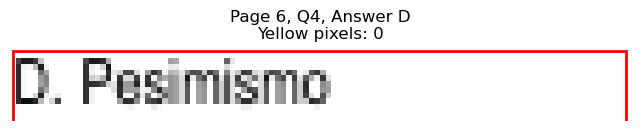


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)
Page 6, Q5 - A: Detected box: x0=56.6, y0=442.8, x1=150.0, y1=455.5
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 443
Page 6, Q5, A: Yellow percentage: 0.0%


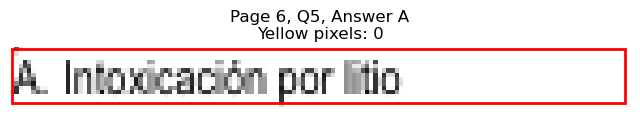

Page 6, Q5 - B: Detected box: x0=56.6, y0=455.5, x1=119.4, y1=468.1
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 311
Page 6, Q5, B: Yellow percentage: 0.0%


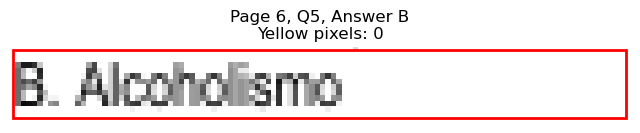

Page 6, Q5 - C: Detected box: x0=315.4, y0=442.8, x1=422.8, y1=455.5
Page 6, Q5, C: Yellow pixels: 1671
Page 6, Q5, C: Total non-white pixels: 2212
Page 6, Q5, C: Yellow percentage: 75.5%


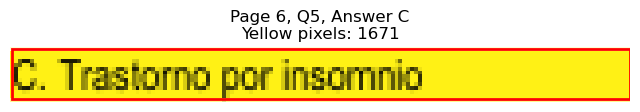

Page 6, Q5 - D: Detected box: x0=315.4, y0=455.5, x1=395.7, y1=468.1
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 386
Page 6, Q5, D: Yellow percentage: 0.0%


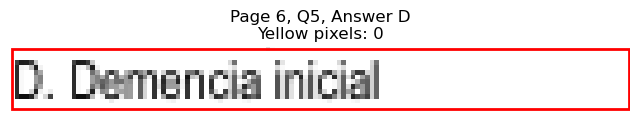


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)
Page 6, Q6 - A: Detected box: x0=56.6, y0=493.4, x1=116.4, y1=506.0
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 284
Page 6, Q6, A: Yellow percentage: 0.0%


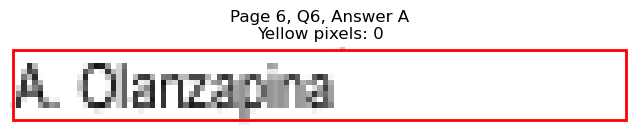

Page 6, Q6 - B: Detected box: x0=56.6, y0=506.0, x1=114.5, y1=518.6
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 306
Page 6, Q6, B: Yellow percentage: 0.0%


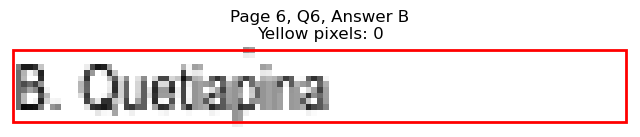

Page 6, Q6 - C: Detected box: x0=315.4, y0=493.4, x1=368.7, y1=506.0
Page 6, Q6, C: Yellow pixels: 104
Page 6, Q6, C: Total non-white pixels: 463
Page 6, Q6, C: Yellow percentage: 22.5%


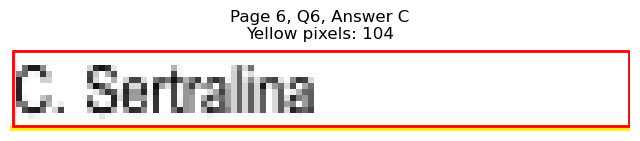

Page 6, Q6 - D: Detected box: x0=315.4, y0=506.0, x1=376.6, y1=518.6
Page 6, Q6, D: Yellow pixels: 1206
Page 6, Q6, D: Total non-white pixels: 1568
Page 6, Q6, D: Yellow percentage: 76.9%


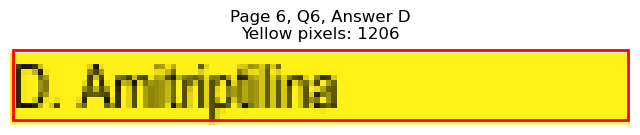


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)
Page 6, Q7 - A: Detected box: x0=56.6, y0=581.7, x1=151.1, y1=594.3
Page 6, Q7, A: Yellow pixels: 146
Page 6, Q7, A: Total non-white pixels: 593
Page 6, Q7, A: Yellow percentage: 24.6%


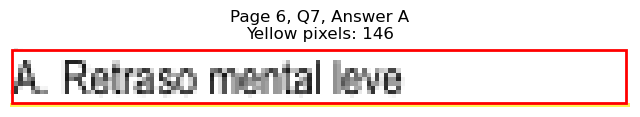

Page 6, Q7 - B: Detected box: x0=56.6, y0=594.3, x1=176.2, y1=606.9
Page 6, Q7, B: Yellow pixels: 1738
Page 6, Q7, B: Total non-white pixels: 2223
Page 6, Q7, B: Yellow percentage: 78.2%


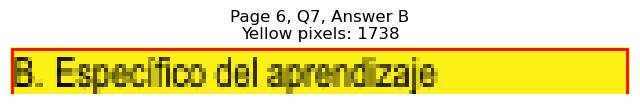

Page 6, Q7 - C: Detected box: x0=315.4, y0=581.7, x1=470.0, y1=594.3
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 782
Page 6, Q7, C: Yellow percentage: 0.0%


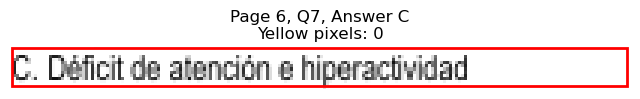

Page 6, Q7 - D: Detected box: x0=315.4, y0=594.3, x1=541.2, y1=606.9
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 1155
Page 6, Q7, D: Yellow percentage: 0.0%


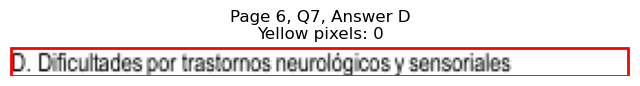


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)
Page 6, Q8 - A: Detected box: x0=56.6, y0=632.2, x1=178.7, y1=644.9
Page 6, Q8, A: Yellow pixels: 1780
Page 6, Q8, A: Total non-white pixels: 2249
Page 6, Q8, A: Yellow percentage: 79.1%


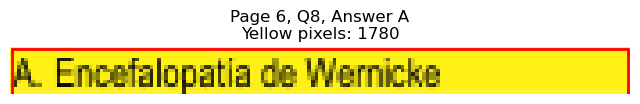

Page 6, Q8 - B: Detected box: x0=56.6, y0=644.8, x1=143.1, y1=657.5
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 420
Page 6, Q8, B: Yellow percentage: 0.0%


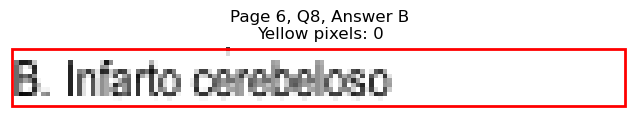

Page 6, Q8 - C: Detected box: x0=315.4, y0=632.2, x1=406.7, y1=644.9
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 424
Page 6, Q8, C: Yellow percentage: 0.0%


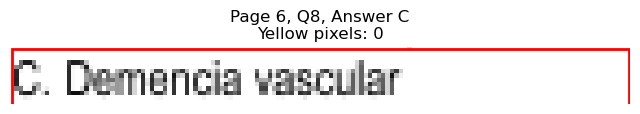

Page 6, Q8 - D: Detected box: x0=315.4, y0=644.8, x1=407.2, y1=657.5
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 440
Page 6, Q8, D: Yellow percentage: 0.0%


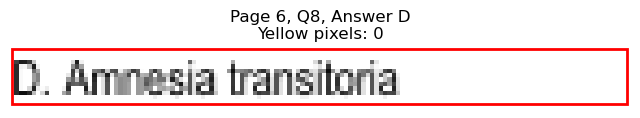


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)
Page 6, Q9 - A: Detected box: x0=56.6, y0=720.6, x1=159.0, y1=733.2
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 490
Page 6, Q9, A: Yellow percentage: 0.0%


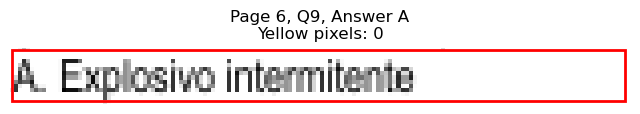

Page 6, Q9 - B: Detected box: x0=56.6, y0=733.2, x1=157.1, y1=745.8
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 492
Page 6, Q9, B: Yellow percentage: 0.0%


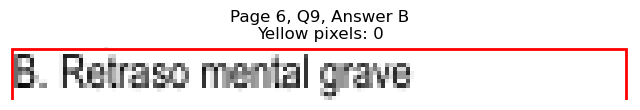

Page 6, Q9 - C: Detected box: x0=315.4, y0=720.6, x1=388.3, y1=733.2
Page 6, Q9, C: Yellow pixels: 124
Page 6, Q9, C: Total non-white pixels: 471
Page 6, Q9, C: Yellow percentage: 26.3%


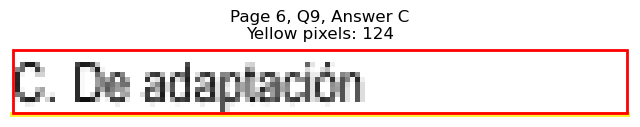

Page 6, Q9 - D: Detected box: x0=315.4, y0=733.2, x1=378.3, y1=745.8
Page 6, Q9, D: Yellow pixels: 1248
Page 6, Q9, D: Total non-white pixels: 1482
Page 6, Q9, D: Yellow percentage: 84.2%


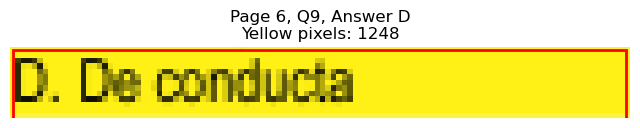


Page 6, Q9 - Selected Answer: D (based on yellow pixel count)

Page 7: Found 12 questions
Page 7, Q1 - A: Detected box: x0=56.6, y0=127.2, x1=244.4, y1=139.9
Page 7, Q1, A: Yellow pixels: 2220
Page 7, Q1, A: Total non-white pixels: 2938
Page 7, Q1, A: Yellow percentage: 75.6%


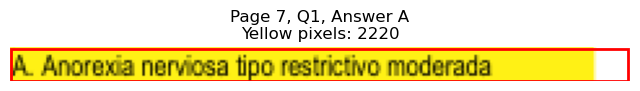

Page 7, Q1 - B: Detected box: x0=56.6, y0=139.9, x1=277.5, y1=152.6
Page 7, Q1, B: Yellow pixels: 224
Page 7, Q1, B: Total non-white pixels: 1320
Page 7, Q1, B: Yellow percentage: 17.0%


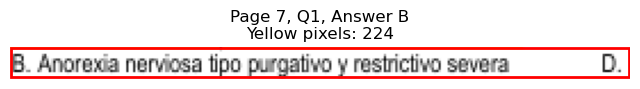

Page 7, Q1 - C: Detected box: x0=315.4, y0=127.2, x1=496.1, y1=139.9
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 853
Page 7, Q1, C: Yellow percentage: 0.0%


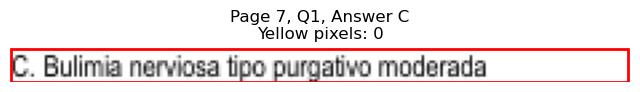

Page 7, Q1 - D: Detected box: x0=315.4, y0=139.9, x1=449.3, y1=152.6
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 655
Page 7, Q1, D: Yellow percentage: 0.0%


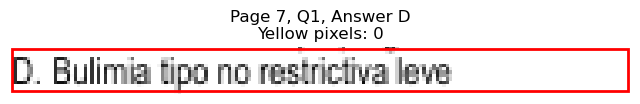


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)
Page 7, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=152.1, y1=203.0
Page 7, Q2, A: Yellow pixels: 1558
Page 7, Q2, A: Total non-white pixels: 1911
Page 7, Q2, A: Yellow percentage: 81.5%


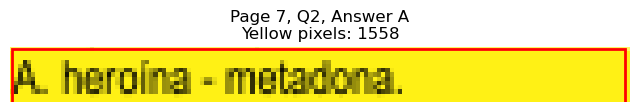

Page 7, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=151.6, y1=215.6
Page 7, Q2, B: Yellow pixels: 146
Page 7, Q2, B: Total non-white pixels: 540
Page 7, Q2, B: Yellow percentage: 27.0%


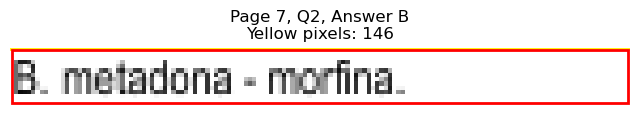

Page 7, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=423.3, y1=203.0
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 507
Page 7, Q2, C: Yellow percentage: 0.0%


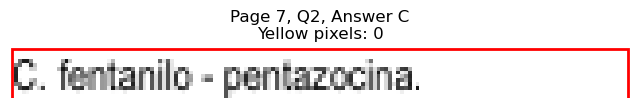

Page 7, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=423.3, y1=215.6
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 482
Page 7, Q2, D: Yellow percentage: 0.0%


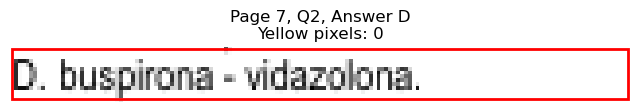


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)
Page 7, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=152.1, y1=253.5
Page 7, Q3, A: Yellow pixels: 1586
Page 7, Q3, A: Total non-white pixels: 2058
Page 7, Q3, A: Yellow percentage: 77.1%


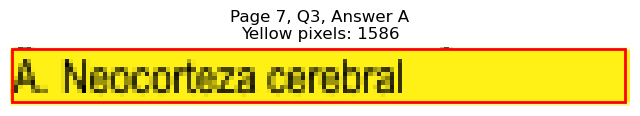

Page 7, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=187.7, y1=266.1
Page 7, Q3, B: Yellow pixels: 182
Page 7, Q3, B: Total non-white pixels: 824
Page 7, Q3, B: Yellow percentage: 22.1%


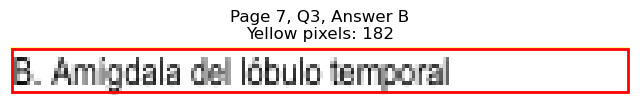

Page 7, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=366.7, y1=253.5
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 238
Page 7, Q3, C: Yellow percentage: 0.0%


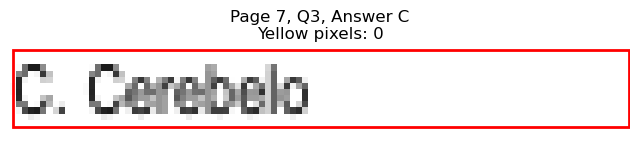

Page 7, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=390.8, y1=266.1
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 386
Page 7, Q3, D: Yellow percentage: 0.0%


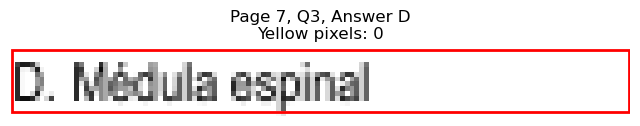


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)
Page 7, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=98.4, y1=304.0
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 195
Page 7, Q4, A: Yellow percentage: 0.0%


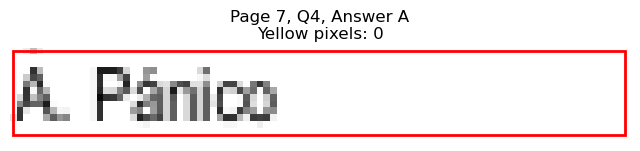

Page 7, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=155.5, y1=316.6
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 486
Page 7, Q4, B: Yellow percentage: 0.0%


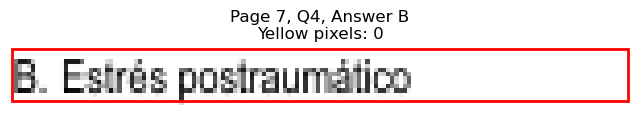

Page 7, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=420.3, y1=304.0
Page 7, Q4, C: Yellow pixels: 1673
Page 7, Q4, C: Total non-white pixels: 2184
Page 7, Q4, C: Yellow percentage: 76.6%


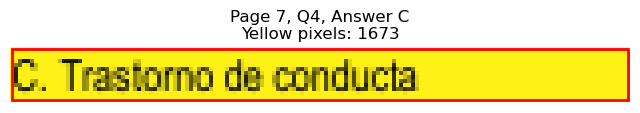

Page 7, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=416.3, y1=316.6
Page 7, Q4, D: Yellow pixels: 152
Page 7, Q4, D: Total non-white pixels: 786
Page 7, Q4, D: Yellow percentage: 19.3%


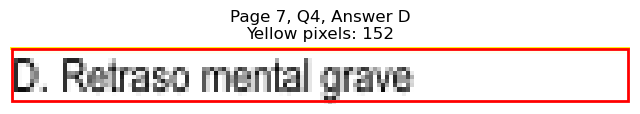


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)
Page 7, Q5 - A: Detected box: x0=56.6, y0=341.9, x1=127.5, y1=354.6
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 363
Page 7, Q5, A: Yellow percentage: 0.0%


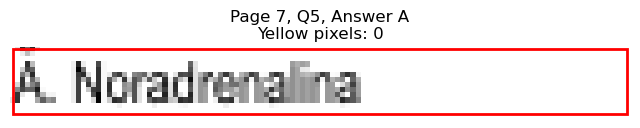

Page 7, Q5 - B: Detected box: x0=56.6, y0=354.5, x1=114.5, y1=367.2
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 284
Page 7, Q5, B: Yellow percentage: 0.0%


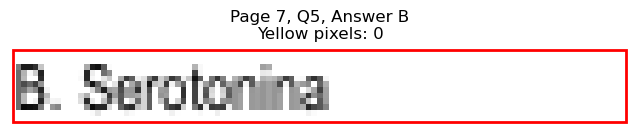

Page 7, Q5 - C: Detected box: x0=315.4, y0=341.9, x1=375.7, y1=354.6
Page 7, Q5, C: Yellow pixels: 1214
Page 7, Q5, C: Total non-white pixels: 1554
Page 7, Q5, C: Yellow percentage: 78.1%


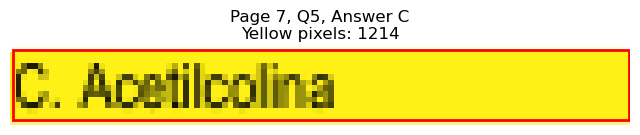

Page 7, Q5 - D: Detected box: x0=315.4, y0=354.5, x1=355.1, y1=367.2
Page 7, Q5, D: Yellow pixels: 91
Page 7, Q5, D: Total non-white pixels: 265
Page 7, Q5, D: Yellow percentage: 34.3%


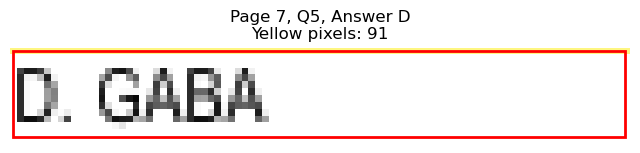


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)
Page 7, Q6 - A: Detected box: x0=56.6, y0=392.3, x1=110.9, y1=405.0
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 354
Page 7, Q6, A: Yellow percentage: 0.0%


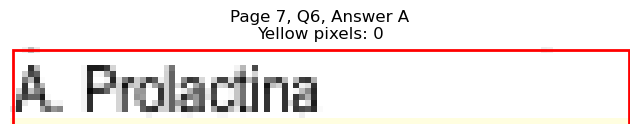

Page 7, Q6 - B: Detected box: x0=56.6, y0=404.9, x1=123.5, y1=417.6
Page 7, Q6, B: Yellow pixels: 1271
Page 7, Q6, B: Total non-white pixels: 1652
Page 7, Q6, B: Yellow percentage: 76.9%


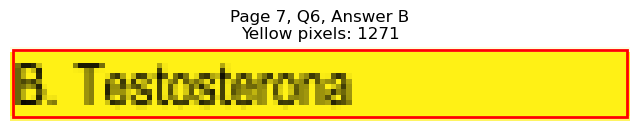

Page 7, Q6 - C: Detected box: x0=315.4, y0=392.3, x1=391.7, y1=405.0
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 392
Page 7, Q6, C: Yellow percentage: 0.0%


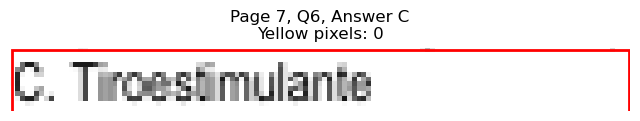

Page 7, Q6 - D: Detected box: x0=315.4, y0=404.9, x1=378.7, y1=417.6
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 296
Page 7, Q6, D: Yellow percentage: 0.0%


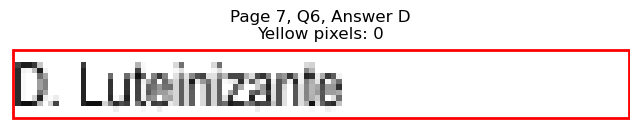


Page 7, Q6 - Selected Answer: B (based on yellow pixel count)
Page 7, Q7 - A: Detected box: x0=56.6, y0=442.8, x1=144.0, y1=455.5
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 432
Page 7, Q7, A: Yellow percentage: 0.0%


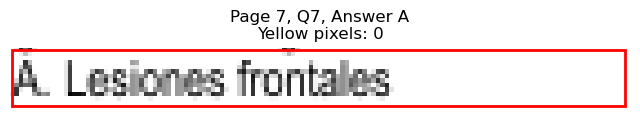

Page 7, Q7 - B: Detected box: x0=56.6, y0=455.5, x1=127.9, y1=468.1
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 357
Page 7, Q7, B: Yellow percentage: 0.0%


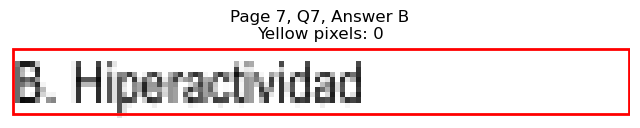

Page 7, Q7 - C: Detected box: x0=315.4, y0=442.8, x1=426.3, y1=455.5
Page 7, Q7, C: Yellow pixels: 1727
Page 7, Q7, C: Total non-white pixels: 2268
Page 7, Q7, C: Yellow percentage: 76.1%


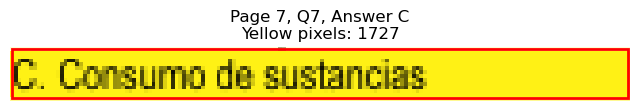

Page 7, Q7 - D: Detected box: x0=315.4, y0=455.5, x1=421.4, y1=468.1
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 543
Page 7, Q7, D: Yellow percentage: 0.0%


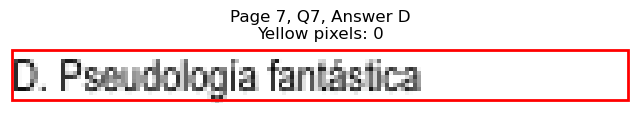


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)
Page 7, Q8 - A: Detected box: x0=56.6, y0=493.4, x1=95.4, y1=506.0
Page 7, Q8, A: Yellow pixels: 1049
Page 7, Q8, A: Total non-white pixels: 1170
Page 7, Q8, A: Yellow percentage: 89.7%


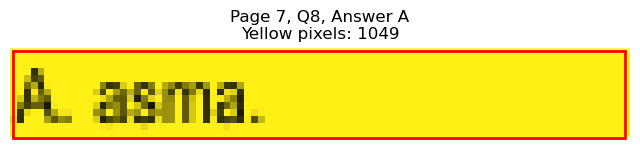

Page 7, Q8 - B: Detected box: x0=56.6, y0=506.0, x1=135.0, y1=518.6
Page 7, Q8, B: Yellow pixels: 130
Page 7, Q8, B: Total non-white pixels: 469
Page 7, Q8, B: Yellow percentage: 27.7%


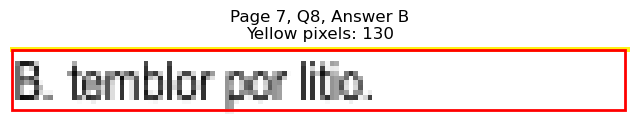

Page 7, Q8 - C: Detected box: x0=315.4, y0=493.4, x1=384.8, y1=506.0
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 324
Page 7, Q8, C: Yellow percentage: 0.0%


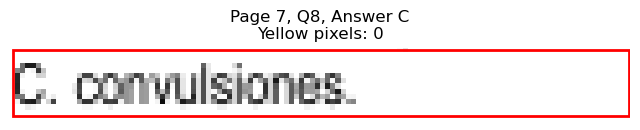

Page 7, Q8 - D: Detected box: x0=315.4, y0=506.0, x1=367.1, y1=518.6
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 234
Page 7, Q8, D: Yellow percentage: 0.0%


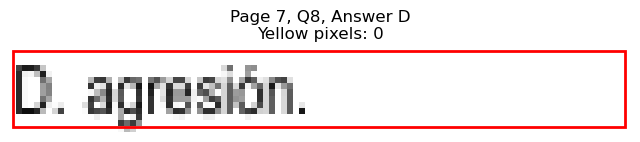


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)
Page 7, Q9 - A: Detected box: x0=56.6, y0=543.8, x1=93.9, y1=556.4
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 171
Page 7, Q9, A: Yellow percentage: 0.0%


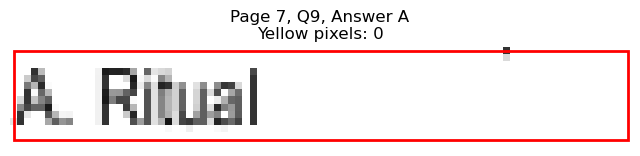

Page 7, Q9 - B: Detected box: x0=56.6, y0=556.5, x1=113.9, y1=569.1
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 272
Page 7, Q9, B: Yellow percentage: 0.0%


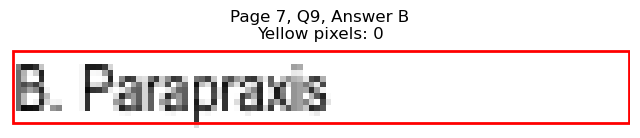

Page 7, Q9 - C: Detected box: x0=315.4, y0=543.8, x1=371.7, y1=556.4
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 275
Page 7, Q9, C: Yellow percentage: 0.0%


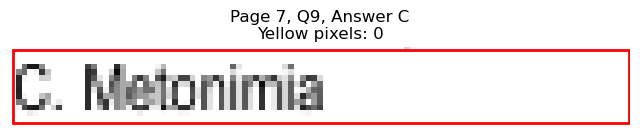

Page 7, Q9 - D: Detected box: x0=315.4, y0=556.5, x1=372.7, y1=569.1
Page 7, Q9, D: Yellow pixels: 1200
Page 7, Q9, D: Total non-white pixels: 1512
Page 7, Q9, D: Yellow percentage: 79.4%


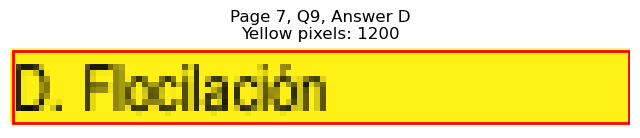


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)
Page 7, Q10 - A: Detected box: x0=56.6, y0=606.9, x1=202.7, y1=619.5
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 706
Page 7, Q10, A: Yellow percentage: 0.0%


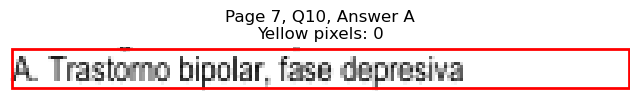

Page 7, Q10 - B: Detected box: x0=56.6, y0=619.6, x1=121.5, y1=632.3
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 314
Page 7, Q10, B: Yellow percentage: 0.0%


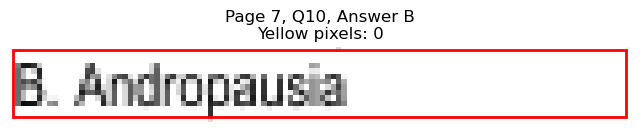

Page 7, Q10 - C: Detected box: x0=315.4, y0=606.9, x1=431.3, y1=619.5
Page 7, Q10, C: Yellow pixels: 1744
Page 7, Q10, C: Total non-white pixels: 2338
Page 7, Q10, C: Yellow percentage: 74.6%


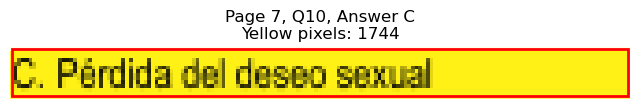

Page 7, Q10 - D: Detected box: x0=315.4, y0=619.6, x1=405.8, y1=632.3
Page 7, Q10, D: Yellow pixels: 141
Page 7, Q10, D: Total non-white pixels: 583
Page 7, Q10, D: Yellow percentage: 24.2%


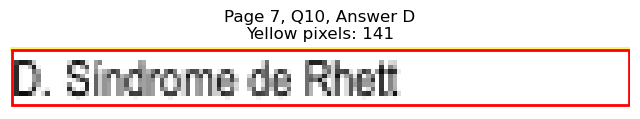


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)
Page 7, Q11 - A: Detected box: x0=56.6, y0=657.4, x1=144.5, y1=670.1
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 422
Page 7, Q11, A: Yellow percentage: 0.0%


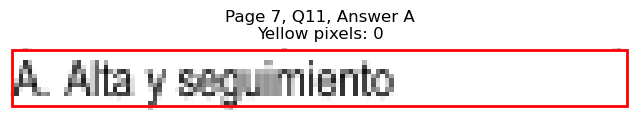

Page 7, Q11 - B: Detected box: x0=56.6, y0=670.0, x1=159.0, y1=682.7
Page 7, Q11, B: Yellow pixels: 0
Page 7, Q11, B: Total non-white pixels: 488
Page 7, Q11, B: Yellow percentage: 0.0%


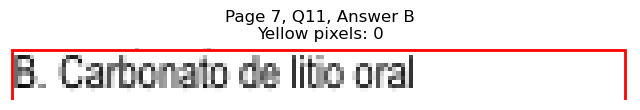

Page 7, Q11 - C: Detected box: x0=315.4, y0=657.4, x1=422.8, y1=670.1
Page 7, Q11, C: Yellow pixels: 158
Page 7, Q11, C: Total non-white pixels: 639
Page 7, Q11, C: Yellow percentage: 24.7%


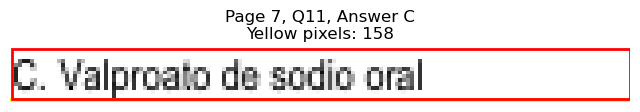

Page 7, Q11 - D: Detected box: x0=315.4, y0=670.0, x1=413.8, y1=682.7
Page 7, Q11, D: Yellow pixels: 1556
Page 7, Q11, D: Total non-white pixels: 1937
Page 7, Q11, D: Yellow percentage: 80.3%


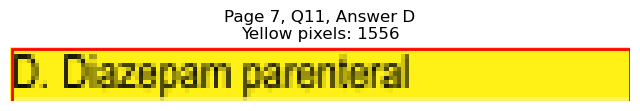


Page 7, Q11 - Selected Answer: D (based on yellow pixel count)
Page 7, Q12 - A: Detected box: x0=56.6, y0=720.6, x1=100.9, y1=733.2
Page 7, Q12, A: Yellow pixels: 0
Page 7, Q12, A: Total non-white pixels: 200
Page 7, Q12, A: Yellow percentage: 0.0%


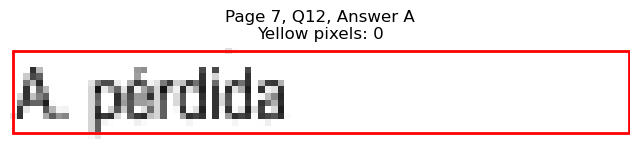

Page 7, Q12 - B: Detected box: x0=56.6, y0=733.2, x1=111.4, y1=745.8
Page 7, Q12, B: Yellow pixels: 0
Page 7, Q12, B: Total non-white pixels: 266
Page 7, Q12, B: Yellow percentage: 0.0%


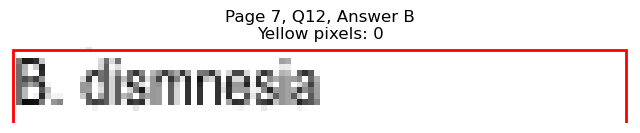

Page 7, Q12 - C: Detected box: x0=315.4, y0=720.6, x1=348.1, y1=733.2
Page 7, Q12, C: Yellow pixels: 1003
Page 7, Q12, C: Total non-white pixels: 1176
Page 7, Q12, C: Yellow percentage: 85.3%


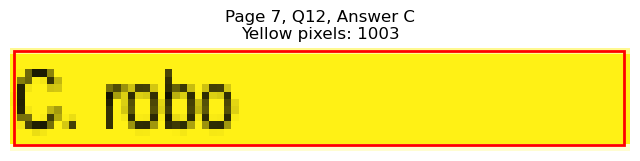

Page 7, Q12 - D: Detected box: x0=315.4, y0=733.2, x1=365.8, y1=745.8
Page 7, Q12, D: Yellow pixels: 0
Page 7, Q12, D: Total non-white pixels: 327
Page 7, Q12, D: Yellow percentage: 0.0%


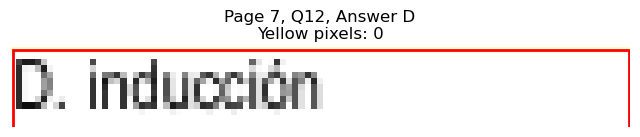


Page 7, Q12 - Selected Answer: C (based on yellow pixel count)

Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=146.1, y1=127.3
Page 8, Q1, A: Yellow pixels: 141
Page 8, Q1, A: Total non-white pixels: 551
Page 8, Q1, A: Yellow percentage: 25.6%


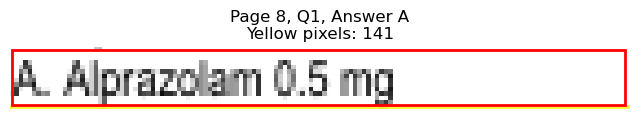

Page 8, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=168.1, y1=139.9
Page 8, Q1, B: Yellow pixels: 1646
Page 8, Q1, B: Total non-white pixels: 2119
Page 8, Q1, B: Yellow percentage: 77.7%


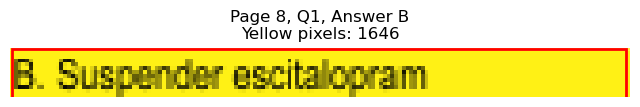

Page 8, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=404.2, y1=127.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 455
Page 8, Q1, C: Yellow percentage: 0.0%


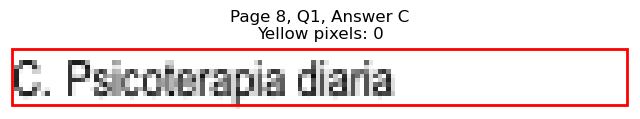

Page 8, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=430.4, y1=139.9
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 550
Page 8, Q1, D: Yellow percentage: 0.0%


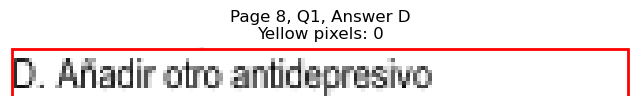


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)
Page 8, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=132.5, y1=177.8
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 322
Page 8, Q2, A: Yellow percentage: 0.0%


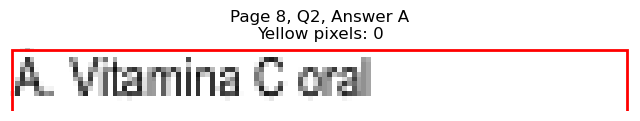

Page 8, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=159.6, y1=190.4
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 522
Page 8, Q2, B: Yellow percentage: 0.0%


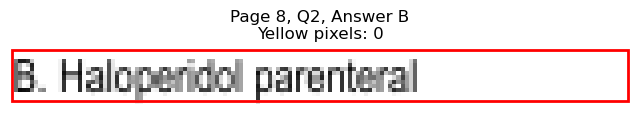

Page 8, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=405.8, y1=177.8
Page 8, Q2, C: Yellow pixels: 1
Page 8, Q2, C: Total non-white pixels: 568
Page 8, Q2, C: Yellow percentage: 0.2%


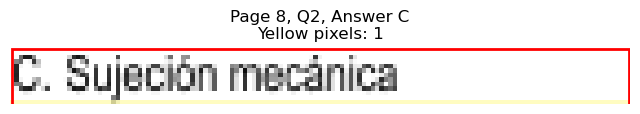

Page 8, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=437.3, y1=190.4
Page 8, Q2, D: Yellow pixels: 1610
Page 8, Q2, D: Total non-white pixels: 2422
Page 8, Q2, D: Yellow percentage: 66.5%


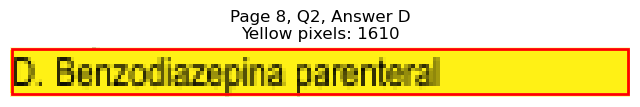


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)
Page 8, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=163.1, y1=266.1
Page 8, Q3, A: Yellow pixels: 158
Page 8, Q3, A: Total non-white pixels: 684
Page 8, Q3, A: Yellow percentage: 23.1%


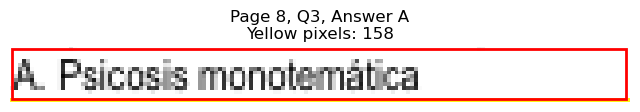

Page 8, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=166.1, y1=278.7
Page 8, Q3, B: Yellow pixels: 1660
Page 8, Q3, B: Total non-white pixels: 2093
Page 8, Q3, B: Yellow percentage: 79.3%


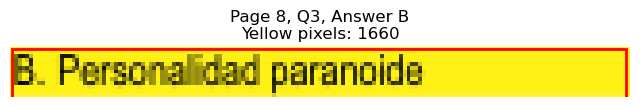

Page 8, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=378.2, y1=266.1
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 296
Page 8, Q3, C: Yellow percentage: 0.0%


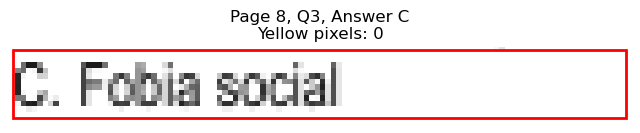

Page 8, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=398.2, y1=278.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 398
Page 8, Q3, D: Yellow percentage: 0.0%


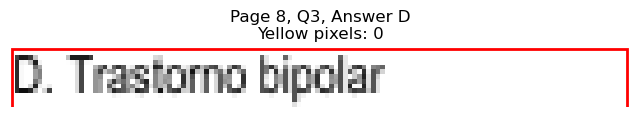


Page 8, Q3 - Selected Answer: B (based on yellow pixel count)
Page 8, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=99.9, y1=341.8
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 206
Page 8, Q4, A: Yellow percentage: 0.0%


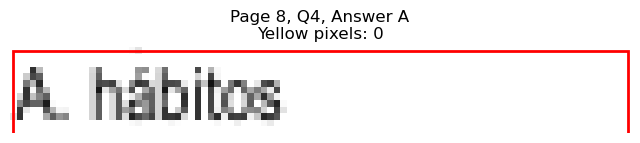

Page 8, Q4 - B: Detected box: x0=56.6, y0=266.0, x1=123.6, y1=278.7
Page 8, Q4, B: Yellow pixels: 1101
Page 8, Q4, B: Total non-white pixels: 1534
Page 8, Q4, B: Yellow percentage: 71.8%


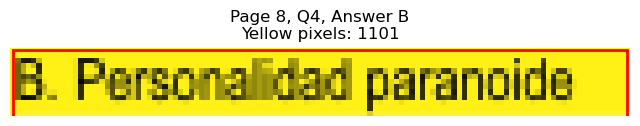

Page 8, Q4 - C: Detected box: x0=315.4, y0=329.2, x1=385.3, y1=341.8
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 337
Page 8, Q4, C: Yellow percentage: 0.0%


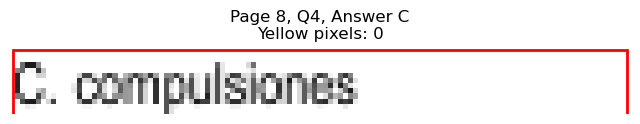

Page 8, Q4 - D: Detected box: x0=315.4, y0=341.9, x1=366.7, y1=354.6
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 242
Page 8, Q4, D: Yellow percentage: 0.0%


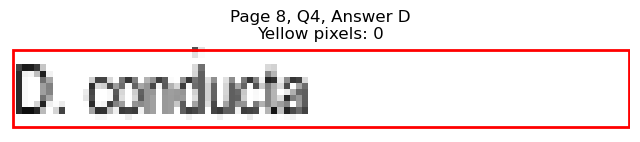


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)
Page 8, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=115.0, y1=430.3
Page 8, Q5, A: Yellow pixels: 109
Page 8, Q5, A: Total non-white pixels: 393
Page 8, Q5, A: Yellow percentage: 27.7%


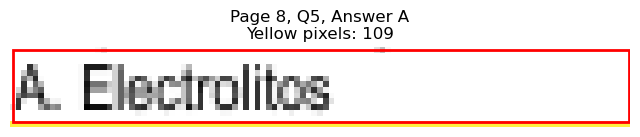

Page 8, Q5 - B: Detected box: x0=56.6, y0=430.2, x1=132.0, y1=442.9
Page 8, Q5, B: Yellow pixels: 1380
Page 8, Q5, B: Total non-white pixels: 1651
Page 8, Q5, B: Yellow percentage: 83.6%


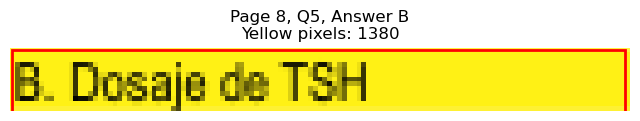

Page 8, Q5 - C: Detected box: x0=315.4, y0=417.6, x1=394.3, y1=430.3
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 367
Page 8, Q5, C: Yellow percentage: 0.0%


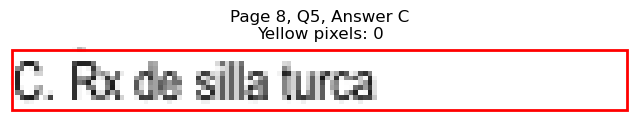

Page 8, Q5 - D: Detected box: x0=315.4, y0=430.2, x1=359.1, y1=442.9
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 188
Page 8, Q5, D: Yellow percentage: 0.0%


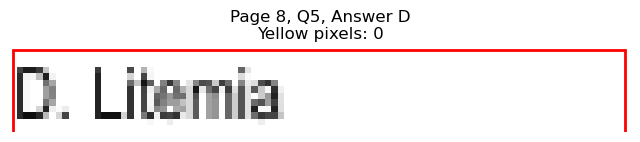


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)
Page 8, Q6 - A: Detected box: x0=56.6, y0=506.0, x1=162.1, y1=518.6
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 499
Page 8, Q6, A: Yellow percentage: 0.0%


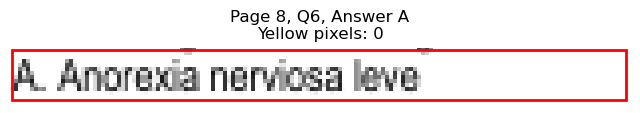

Page 8, Q6 - B: Detected box: x0=56.6, y0=518.6, x1=111.4, y1=531.2
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 249
Page 8, Q6, B: Yellow percentage: 0.0%


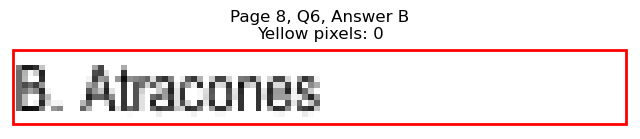

Page 8, Q6 - C: Detected box: x0=315.4, y0=506.0, x1=387.2, y1=518.6
Page 8, Q6, C: Yellow pixels: 123
Page 8, Q6, C: Total non-white pixels: 488
Page 8, Q6, C: Yellow percentage: 25.2%


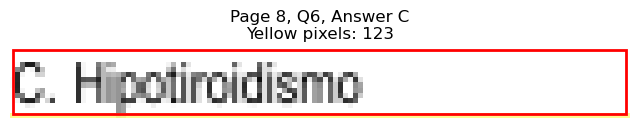

Page 8, Q6 - D: Detected box: x0=315.4, y0=518.6, x1=388.3, y1=531.2
Page 8, Q6, D: Yellow pixels: 1337
Page 8, Q6, D: Total non-white pixels: 1736
Page 8, Q6, D: Yellow percentage: 77.0%


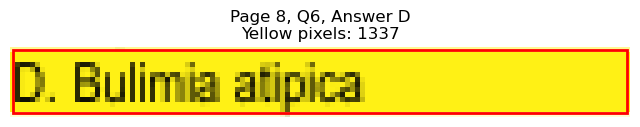


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)
Page 8, Q7 - A: Detected box: x0=56.6, y0=556.5, x1=192.6, y1=569.1
Page 8, Q7, A: Yellow pixels: 1916
Page 8, Q7, A: Total non-white pixels: 2618
Page 8, Q7, A: Yellow percentage: 73.2%


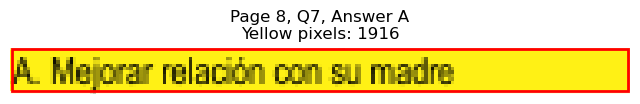

Page 8, Q7 - B: Detected box: x0=56.6, y0=569.1, x1=180.1, y1=581.7
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 768
Page 8, Q7, B: Yellow percentage: 0.0%


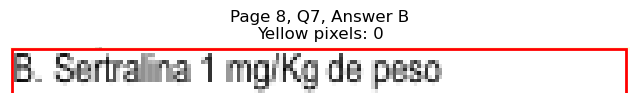

Page 8, Q7 - C: Detected box: x0=315.4, y0=556.5, x1=477.1, y1=569.1
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 809
Page 8, Q7, C: Yellow percentage: 0.0%


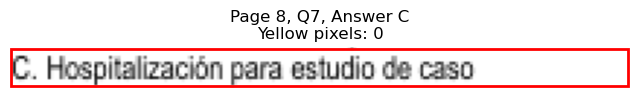

Page 8, Q7 - D: Detected box: x0=315.4, y0=569.1, x1=457.9, y1=581.7
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 672
Page 8, Q7, D: Yellow percentage: 0.0%


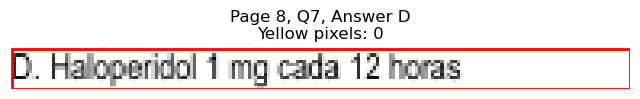


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)
Page 8, Q8 - A: Detected box: x0=56.6, y0=632.2, x1=118.9, y1=644.9
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 273
Page 8, Q8, A: Yellow percentage: 0.0%


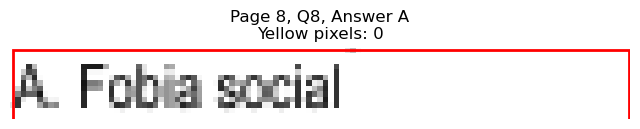

Page 8, Q8 - B: Detected box: x0=56.6, y0=644.8, x1=98.4, y1=657.5
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 199
Page 8, Q8, B: Yellow percentage: 0.0%


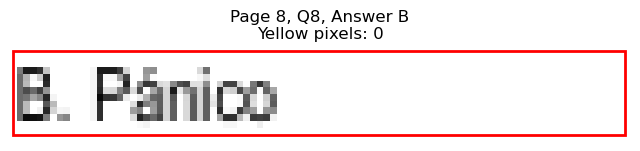

Page 8, Q8 - C: Detected box: x0=315.4, y0=632.2, x1=373.7, y1=644.9
Page 8, Q8, C: Yellow pixels: 1200
Page 8, Q8, C: Total non-white pixels: 1417
Page 8, Q8, C: Yellow percentage: 84.7%


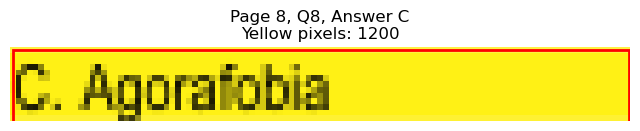

Page 8, Q8 - D: Detected box: x0=315.4, y0=644.8, x1=421.9, y1=657.5
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 548
Page 8, Q8, D: Yellow percentage: 0.0%


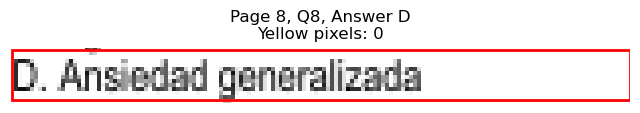


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)
Page 8, Q9 - A: Detected box: x0=56.6, y0=682.6, x1=148.0, y1=695.3
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 398
Page 8, Q9, A: Yellow percentage: 0.0%


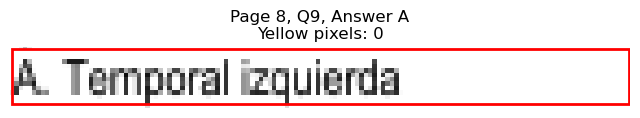

Page 8, Q9 - B: Detected box: x0=56.6, y0=695.4, x1=140.5, y1=708.0
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 417
Page 8, Q9, B: Yellow percentage: 0.0%


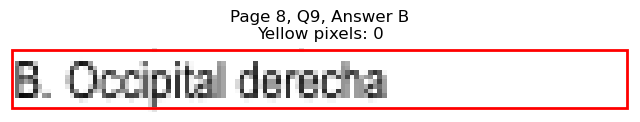

Page 8, Q9 - C: Detected box: x0=315.4, y0=682.6, x1=458.0, y1=695.3
Page 8, Q9, C: Yellow pixels: 1782
Page 8, Q9, C: Total non-white pixels: 2702
Page 8, Q9, C: Yellow percentage: 66.0%


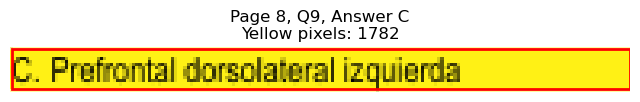

Page 8, Q9 - D: Detected box: x0=315.4, y0=695.4, x1=438.9, y1=708.0
Page 8, Q9, D: Yellow pixels: 1
Page 8, Q9, D: Total non-white pixels: 804
Page 8, Q9, D: Yellow percentage: 0.1%


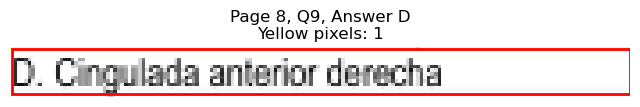


Page 8, Q9 - Selected Answer: C (based on yellow pixel count)
Page 8, Q10 - A: Detected box: x0=56.6, y0=733.2, x1=109.5, y1=745.8
Page 8, Q10, A: Yellow pixels: 1139
Page 8, Q10, A: Total non-white pixels: 1352
Page 8, Q10, A: Yellow percentage: 84.2%


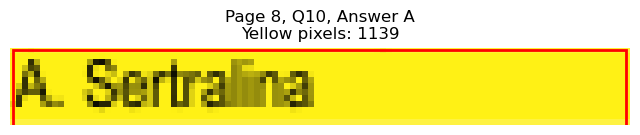

Page 8, Q10 - B: Detected box: x0=56.6, y0=745.8, x1=134.5, y1=758.4
Page 8, Q10, B: Yellow pixels: 129
Page 8, Q10, B: Total non-white pixels: 512
Page 8, Q10, B: Yellow percentage: 25.2%


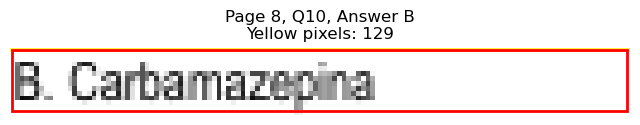

Page 8, Q10 - C: Detected box: x0=315.4, y0=733.2, x1=372.7, y1=745.8
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 252
Page 8, Q10, C: Yellow percentage: 0.0%


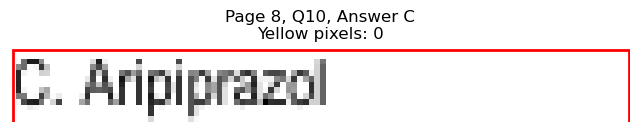

Page 8, Q10 - D: Detected box: x0=315.4, y0=745.8, x1=376.6, y1=758.4
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 322
Page 8, Q10, D: Yellow percentage: 0.0%


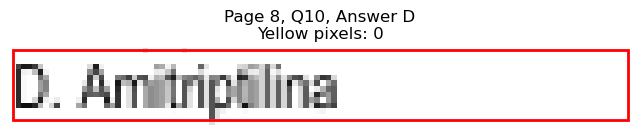


Page 8, Q10 - Selected Answer: A (based on yellow pixel count)

Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=127.2, x1=114.5, y1=139.9
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 284
Page 9, Q1, A: Yellow percentage: 0.0%


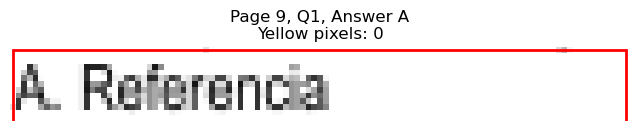

Page 9, Q1 - B: Detected box: x0=56.6, y0=139.9, x1=124.5, y1=152.6
Page 9, Q1, B: Yellow pixels: 1279
Page 9, Q1, B: Total non-white pixels: 1666
Page 9, Q1, B: Yellow percentage: 76.8%


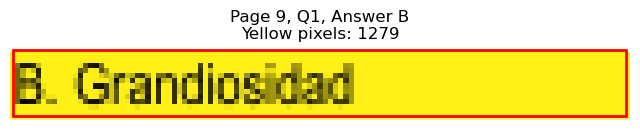

Page 9, Q1 - C: Detected box: x0=315.4, y0=127.2, x1=407.3, y1=139.9
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 449
Page 9, Q1, C: Yellow percentage: 0.0%


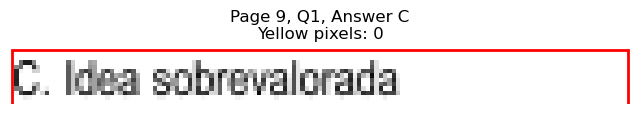

Page 9, Q1 - D: Detected box: x0=315.4, y0=139.9, x1=389.7, y1=152.6
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 343
Page 9, Q1, D: Yellow percentage: 0.0%


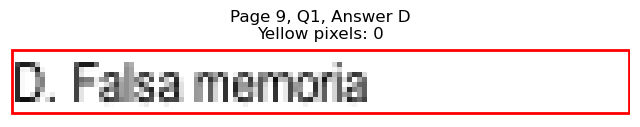


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)
Page 9, Q2 - A: Detected box: x0=56.6, y0=202.9, x1=127.5, y1=215.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 360
Page 9, Q2, A: Yellow percentage: 0.0%


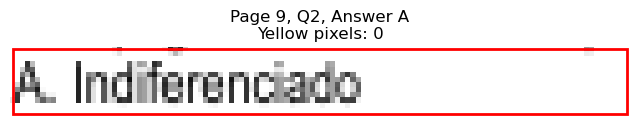

Page 9, Q2 - B: Detected box: x0=56.6, y0=215.6, x1=116.9, y1=228.3
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 300
Page 9, Q2, B: Yellow percentage: 0.0%


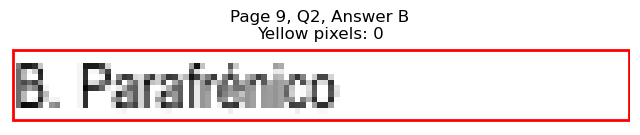

Page 9, Q2 - C: Detected box: x0=315.4, y0=202.9, x1=366.7, y1=215.6
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 232
Page 9, Q2, C: Yellow percentage: 0.0%


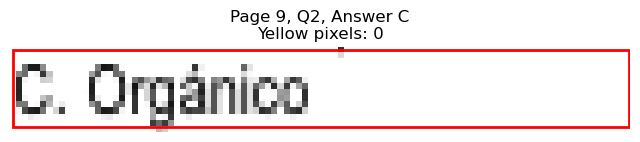

Page 9, Q2 - D: Detected box: x0=315.4, y0=215.6, x1=374.2, y1=228.3
Page 9, Q2, D: Yellow pixels: 1106
Page 9, Q2, D: Total non-white pixels: 1540
Page 9, Q2, D: Yellow percentage: 71.8%


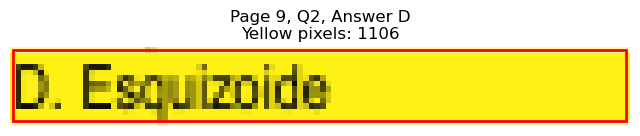


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)
Page 9, Q3 - A: Detected box: x0=56.6, y0=291.4, x1=119.4, y1=304.0
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 294
Page 9, Q3, A: Yellow percentage: 0.0%


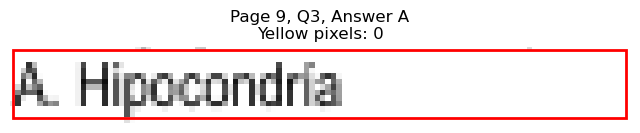

Page 9, Q3 - B: Detected box: x0=56.6, y0=304.0, x1=98.4, y1=316.6
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 202
Page 9, Q3, B: Yellow percentage: 0.0%


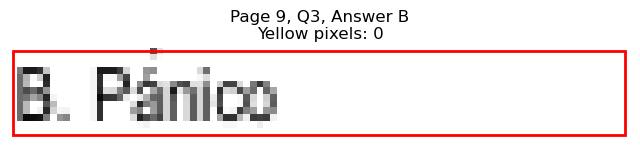

Page 9, Q3 - C: Detected box: x0=315.4, y0=291.4, x1=387.7, y1=304.0
Page 9, Q3, C: Yellow pixels: 123
Page 9, Q3, C: Total non-white pixels: 478
Page 9, Q3, C: Yellow percentage: 25.7%


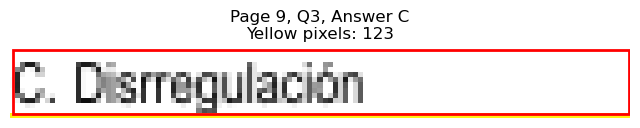

Page 9, Q3 - D: Detected box: x0=315.4, y0=304.0, x1=397.3, y1=316.6
Page 9, Q3, D: Yellow pixels: 1436
Page 9, Q3, D: Total non-white pixels: 1733
Page 9, Q3, D: Yellow percentage: 82.9%


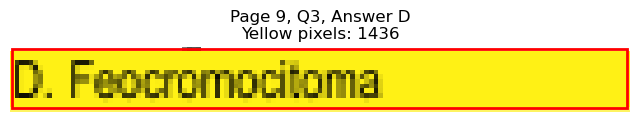


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)
Page 9, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=132.0, y1=354.6
Page 9, Q4, A: Yellow pixels: 1416
Page 9, Q4, A: Total non-white pixels: 1778
Page 9, Q4, A: Yellow percentage: 79.6%


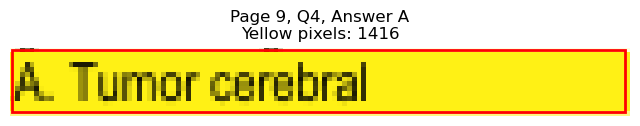

Page 9, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=142.1, y1=367.2
Page 9, Q4, B: Yellow pixels: 137
Page 9, Q4, B: Total non-white pixels: 499
Page 9, Q4, B: Yellow percentage: 27.5%


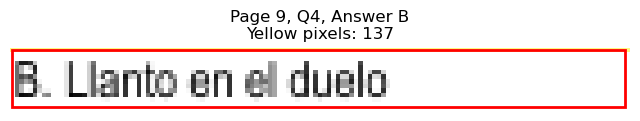

Page 9, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=431.5, y1=354.6
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 521
Page 9, Q4, C: Yellow percentage: 0.0%


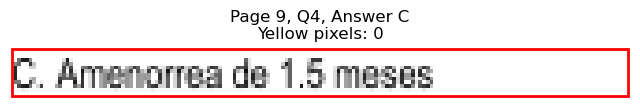

Page 9, Q4 - D: Detected box: x0=315.4, y0=354.5, x1=405.8, y1=367.2
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 456
Page 9, Q4, D: Yellow percentage: 0.0%


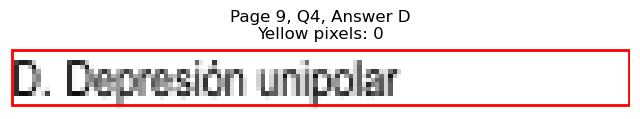


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)
Page 9, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=246.9, y1=405.0
Page 9, Q5, A: Yellow pixels: 2234
Page 9, Q5, A: Total non-white pixels: 2938
Page 9, Q5, A: Yellow percentage: 76.0%


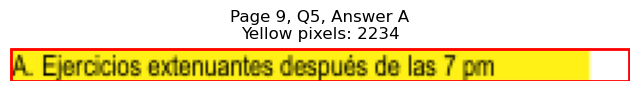

Page 9, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=165.1, y1=417.6
Page 9, Q5, B: Yellow pixels: 157
Page 9, Q5, B: Total non-white pixels: 657
Page 9, Q5, B: Yellow percentage: 23.9%


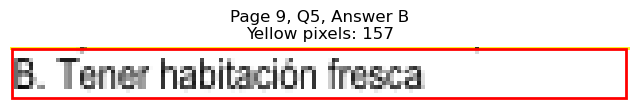

Page 9, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=414.8, y1=405.0
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 507
Page 9, Q5, C: Yellow percentage: 0.0%


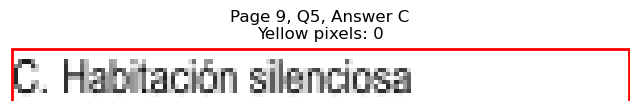

Page 9, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=417.8, y1=417.6
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 501
Page 9, Q5, D: Yellow percentage: 0.0%


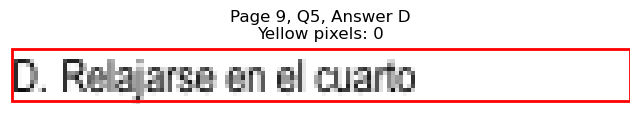


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)
Page 9, Q6 - A: Detected box: x0=56.6, y0=480.8, x1=138.5, y1=493.4
Page 9, Q6, A: Yellow pixels: 133
Page 9, Q6, A: Total non-white pixels: 528
Page 9, Q6, A: Yellow percentage: 25.2%


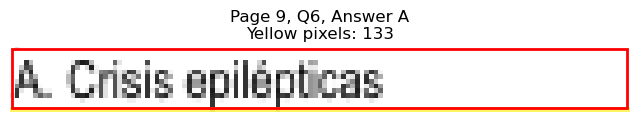

Page 9, Q6 - B: Detected box: x0=56.6, y0=493.4, x1=130.5, y1=506.0
Page 9, Q6, B: Yellow pixels: 1327
Page 9, Q6, B: Total non-white pixels: 1625
Page 9, Q6, B: Yellow percentage: 81.7%


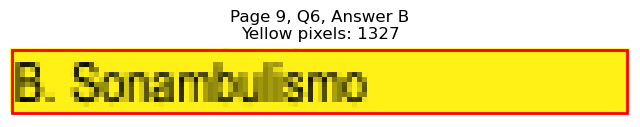

Page 9, Q6 - C: Detected box: x0=315.4, y0=480.8, x1=377.7, y1=493.4
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 299
Page 9, Q6, C: Yellow percentage: 0.0%


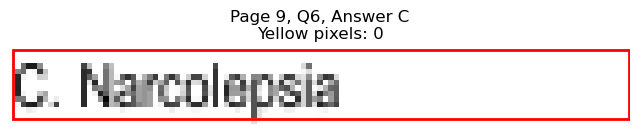

Page 9, Q6 - D: Detected box: x0=315.4, y0=493.4, x1=407.3, y1=506.0
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 440
Page 9, Q6, D: Yellow percentage: 0.0%


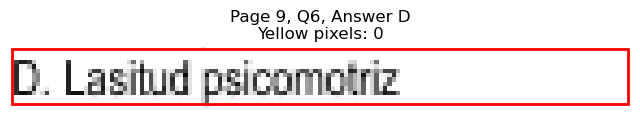


Page 9, Q6 - Selected Answer: B (based on yellow pixel count)
Page 9, Q7 - A: Detected box: x0=56.6, y0=569.1, x1=118.5, y1=581.7
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 286
Page 9, Q7, A: Yellow percentage: 0.0%


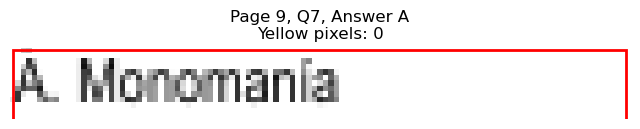

Page 9, Q7 - B: Detected box: x0=56.6, y0=581.7, x1=112.5, y1=594.3
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 276
Page 9, Q7, B: Yellow percentage: 0.0%


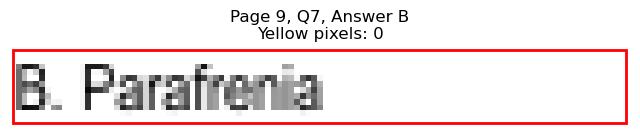

Page 9, Q7 - C: Detected box: x0=315.4, y0=569.1, x1=421.9, y1=581.7
Page 9, Q7, C: Yellow pixels: 2
Page 9, Q7, C: Total non-white pixels: 693
Page 9, Q7, C: Yellow percentage: 0.3%


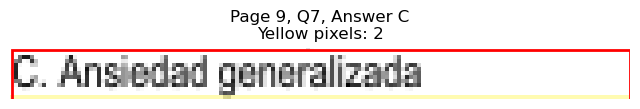

Page 9, Q7 - D: Detected box: x0=315.4, y0=581.7, x1=423.8, y1=594.3
Page 9, Q7, D: Yellow pixels: 1511
Page 9, Q7, D: Total non-white pixels: 2226
Page 9, Q7, D: Yellow percentage: 67.9%


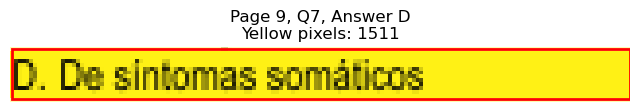


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)
Page 9, Q8 - A: Detected box: x0=56.6, y0=619.6, x1=115.0, y1=632.3
Page 9, Q8, A: Yellow pixels: 109
Page 9, Q8, A: Total non-white pixels: 372
Page 9, Q8, A: Yellow percentage: 29.3%


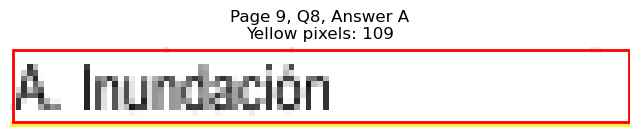

Page 9, Q8 - B: Detected box: x0=56.6, y0=632.2, x1=133.0, y1=644.9
Page 9, Q8, B: Yellow pixels: 1343
Page 9, Q8, B: Total non-white pixels: 1651
Page 9, Q8, B: Yellow percentage: 81.3%


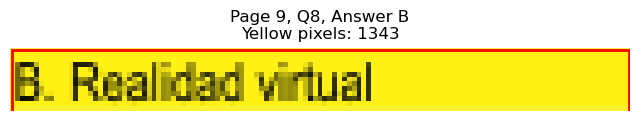

Page 9, Q8 - C: Detected box: x0=315.4, y0=619.6, x1=366.7, y1=632.3
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 239
Page 9, Q8, C: Yellow percentage: 0.0%


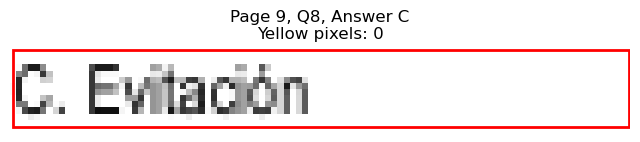

Page 9, Q8 - D: Detected box: x0=315.4, y0=632.2, x1=386.7, y1=644.9
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 368
Page 9, Q8, D: Yellow percentage: 0.0%


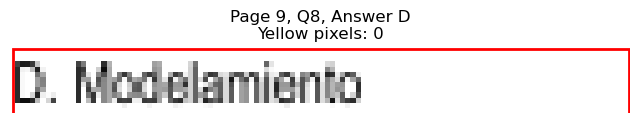


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)
Page 9, Q9 - A: Detected box: x0=56.6, y0=695.4, x1=109.0, y1=708.0
Page 9, Q9, A: Yellow pixels: 1159
Page 9, Q9, A: Total non-white pixels: 1339
Page 9, Q9, A: Yellow percentage: 86.6%


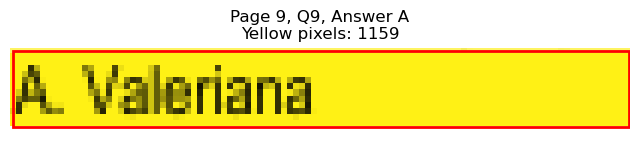

Page 9, Q9 - B: Detected box: x0=56.6, y0=708.0, x1=104.4, y1=720.6
Page 9, Q9, B: Yellow pixels: 99
Page 9, Q9, B: Total non-white pixels: 329
Page 9, Q9, B: Yellow percentage: 30.1%


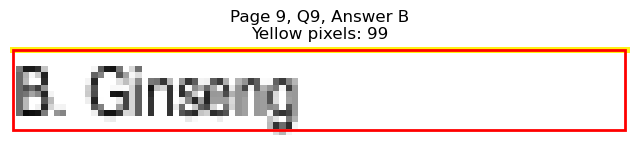

Page 9, Q9 - C: Detected box: x0=315.4, y0=695.4, x1=369.7, y1=708.0
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 259
Page 9, Q9, C: Yellow percentage: 0.0%


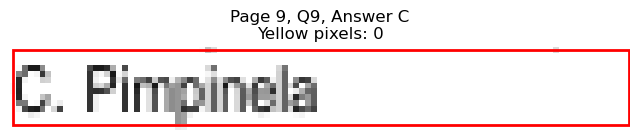

Page 9, Q9 - D: Detected box: x0=315.4, y0=708.0, x1=363.2, y1=720.6
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 234
Page 9, Q9, D: Yellow percentage: 0.0%


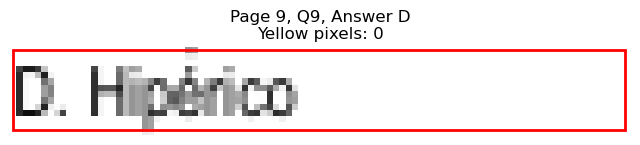


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)
Page 9, Q10 - A: Detected box: x0=56.6, y0=745.8, x1=149.5, y1=758.4
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 414
Page 9, Q10, A: Yellow percentage: 0.0%


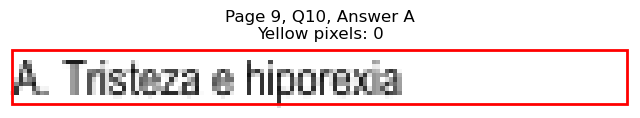

Page 9, Q10 - B: Detected box: x0=56.6, y0=758.5, x1=137.1, y1=771.1
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 395
Page 9, Q10, B: Yellow percentage: 0.0%


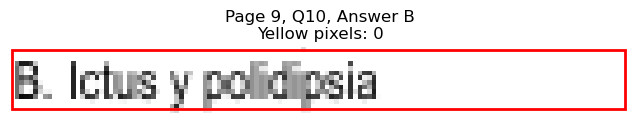

Page 9, Q10 - C: Detected box: x0=315.4, y0=745.8, x1=398.8, y1=758.4
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 390
Page 9, Q10, C: Yellow percentage: 0.0%


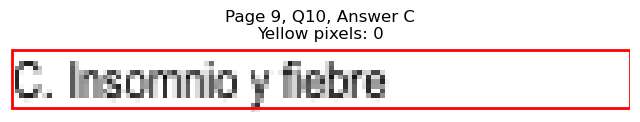

Page 9, Q10 - D: Detected box: x0=315.4, y0=758.5, x1=418.4, y1=771.1
Page 9, Q10, D: Yellow pixels: 1628
Page 9, Q10, D: Total non-white pixels: 2156
Page 9, Q10, D: Yellow percentage: 75.5%


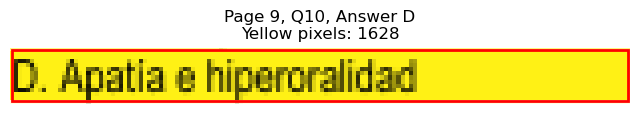


Page 9, Q10 - Selected Answer: D (based on yellow pixel count)

Page 10: Found 11 questions
Page 10, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=110.9, y1=102.1
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 256
Page 10, Q1, A: Yellow percentage: 0.0%


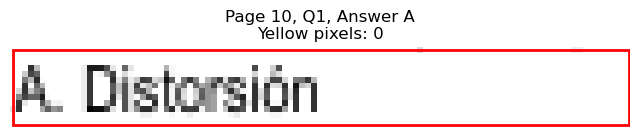

Page 10, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=116.9, y1=114.7
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 283
Page 10, Q1, B: Yellow percentage: 0.0%


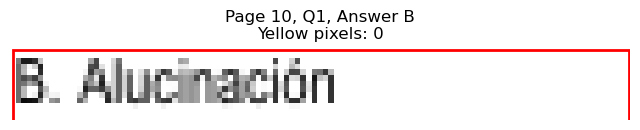

Page 10, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=389.2, y1=102.1
Page 10, Q1, C: Yellow pixels: 1331
Page 10, Q1, C: Total non-white pixels: 1750
Page 10, Q1, C: Yellow percentage: 76.1%


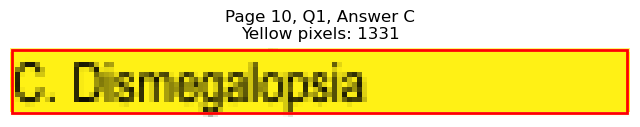

Page 10, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=376.7, y1=114.7
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 433
Page 10, Q1, D: Yellow percentage: 0.0%


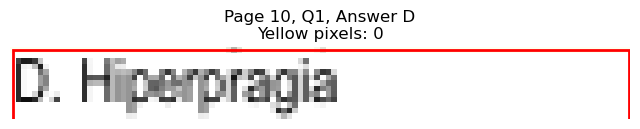


Page 10, Q1 - Selected Answer: C (based on yellow pixel count)
Page 10, Q2 - A: Detected box: x0=56.6, y0=89.4, x1=110.9, y1=102.1
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 256
Page 10, Q2, A: Yellow percentage: 0.0%


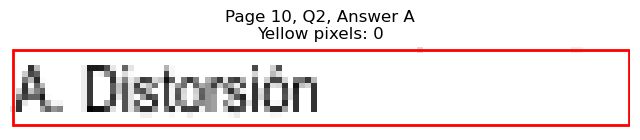

Page 10, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=115.5, y1=165.2
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 286
Page 10, Q2, B: Yellow percentage: 0.0%


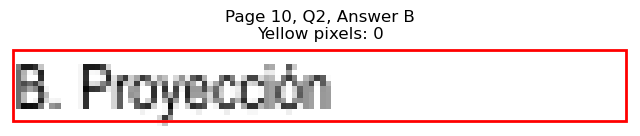

Page 10, Q2 - C: Detected box: x0=315.4, y0=139.9, x1=376.7, y1=152.6
Page 10, Q2, C: Yellow pixels: 1227
Page 10, Q2, C: Total non-white pixels: 1568
Page 10, Q2, C: Yellow percentage: 78.3%


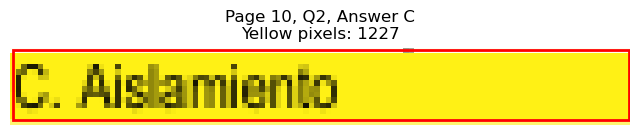

Page 10, Q2 - D: Detected box: x0=315.4, y0=152.5, x1=392.7, y1=165.2
Page 10, Q2, D: Yellow pixels: 128
Page 10, Q2, D: Total non-white pixels: 500
Page 10, Q2, D: Yellow percentage: 25.6%


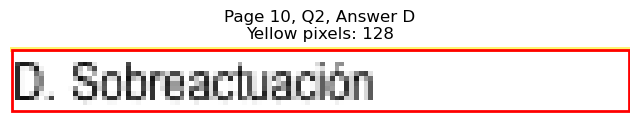


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)
Page 10, Q3 - A: Detected box: x0=56.6, y0=190.3, x1=212.2, y1=203.0
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 977
Page 10, Q3, A: Yellow percentage: 0.0%


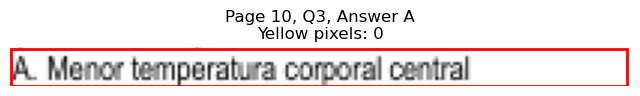

Page 10, Q3 - B: Detected box: x0=56.6, y0=202.9, x1=171.1, y1=215.6
Page 10, Q3, B: Yellow pixels: 1690
Page 10, Q3, B: Total non-white pixels: 2324
Page 10, Q3, B: Yellow percentage: 72.7%


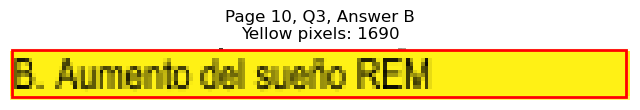

Page 10, Q3 - C: Detected box: x0=315.4, y0=190.3, x1=465.1, y1=203.0
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 679
Page 10, Q3, C: Yellow percentage: 0.0%


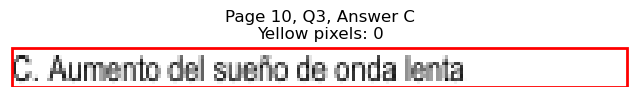

Page 10, Q3 - D: Detected box: x0=315.4, y0=202.9, x1=458.0, y1=215.6
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 653
Page 10, Q3, D: Yellow percentage: 0.0%


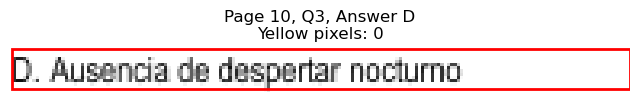


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)
Page 10, Q4 - A: Detected box: x0=56.6, y0=253.4, x1=112.0, y1=266.1
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 244
Page 10, Q4, A: Yellow percentage: 0.0%


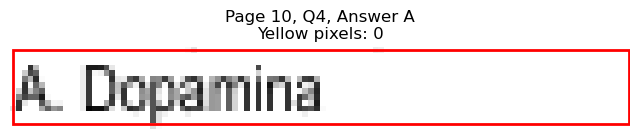

Page 10, Q4 - B: Detected box: x0=56.6, y0=266.0, x1=133.5, y1=278.7
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 376
Page 10, Q4, B: Yellow percentage: 0.0%


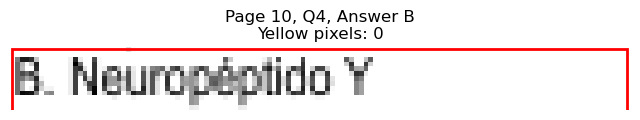

Page 10, Q4 - C: Detected box: x0=315.4, y0=253.4, x1=386.7, y1=266.1
Page 10, Q4, C: Yellow pixels: 1299
Page 10, Q4, C: Total non-white pixels: 1708
Page 10, Q4, C: Yellow percentage: 76.1%


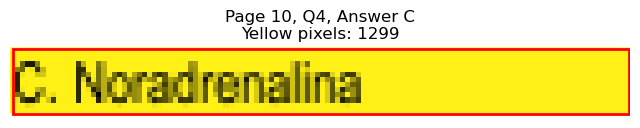

Page 10, Q4 - D: Detected box: x0=315.4, y0=266.0, x1=366.2, y1=278.7
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 333
Page 10, Q4, D: Yellow percentage: 0.0%


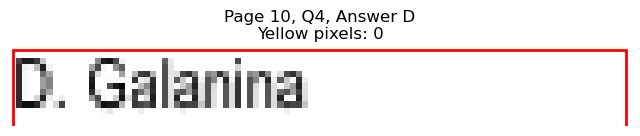


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)
Page 10, Q5 - A: Detected box: x0=56.6, y0=329.2, x1=155.5, y1=341.8
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 477
Page 10, Q5, A: Yellow percentage: 0.0%


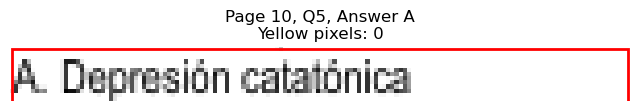

Page 10, Q5 - B: Detected box: x0=56.6, y0=341.9, x1=154.1, y1=354.6
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 498
Page 10, Q5, B: Yellow percentage: 0.0%


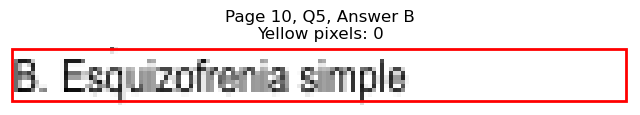

Page 10, Q5 - C: Detected box: x0=315.4, y0=329.2, x1=408.3, y1=341.8
Page 10, Q5, C: Yellow pixels: 1540
Page 10, Q5, C: Total non-white pixels: 1872
Page 10, Q5, C: Yellow percentage: 82.3%


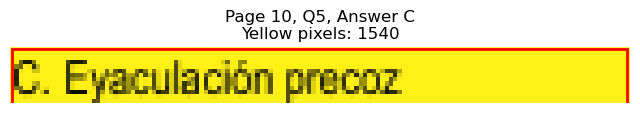

Page 10, Q5 - D: Detected box: x0=315.4, y0=341.9, x1=408.8, y1=354.6
Page 10, Q5, D: Yellow pixels: 141
Page 10, Q5, D: Total non-white pixels: 594
Page 10, Q5, D: Yellow percentage: 23.7%


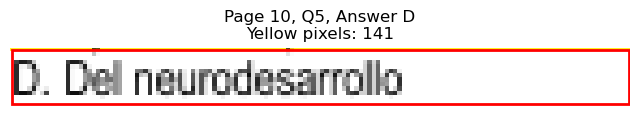


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)
Page 10, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=134.1, y1=430.3
Page 10, Q6, A: Yellow pixels: 1250
Page 10, Q6, A: Total non-white pixels: 1806
Page 10, Q6, A: Yellow percentage: 69.2%


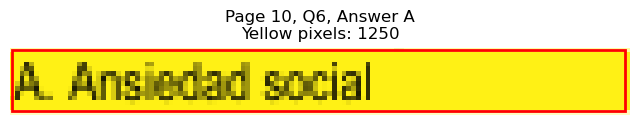

Page 10, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=151.1, y1=442.9
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 590
Page 10, Q6, B: Yellow percentage: 0.0%


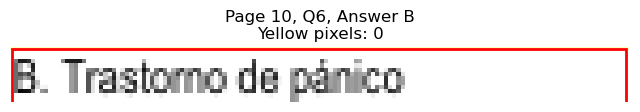

Page 10, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=414.3, y1=430.3
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 490
Page 10, Q6, C: Yellow percentage: 0.0%


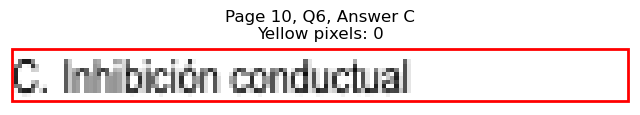

Page 10, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=428.3, y1=442.9
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 578
Page 10, Q6, D: Yellow percentage: 0.0%


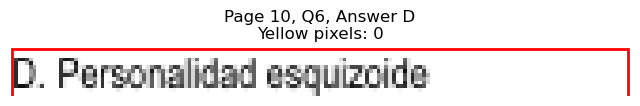


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)
Page 10, Q7 - A: Detected box: x0=56.6, y0=468.1, x1=110.4, y1=480.7
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 253
Page 10, Q7, A: Yellow percentage: 0.0%


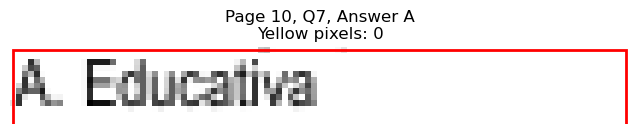

Page 10, Q7 - B: Detected box: x0=56.6, y0=480.8, x1=123.6, y1=493.4
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 342
Page 10, Q7, B: Yellow percentage: 0.0%


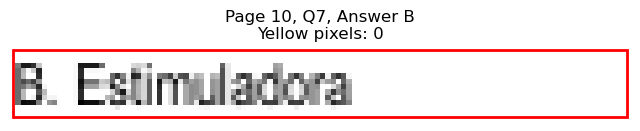

Page 10, Q7 - C: Detected box: x0=315.4, y0=468.1, x1=370.3, y1=480.7
Page 10, Q7, C: Yellow pixels: 1161
Page 10, Q7, C: Total non-white pixels: 1378
Page 10, Q7, C: Yellow percentage: 84.3%


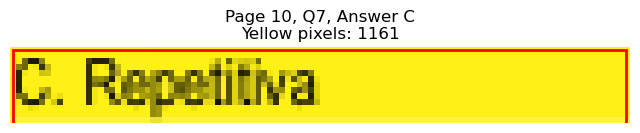

Page 10, Q7 - D: Detected box: x0=315.4, y0=480.8, x1=369.2, y1=493.4
Page 10, Q7, D: Yellow pixels: 105
Page 10, Q7, D: Total non-white pixels: 376
Page 10, Q7, D: Yellow percentage: 27.9%


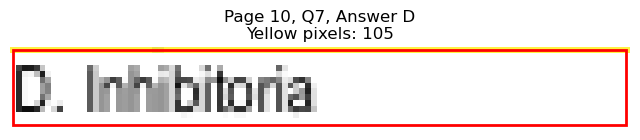


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)
Page 10, Q8 - A: Detected box: x0=56.6, y0=531.2, x1=117.5, y1=543.8
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 394
Page 10, Q8, A: Yellow percentage: 0.0%


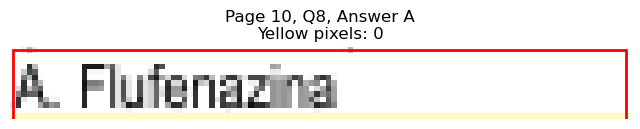

Page 10, Q8 - B: Detected box: x0=56.6, y0=543.8, x1=118.0, y1=556.4
Page 10, Q8, B: Yellow pixels: 1241
Page 10, Q8, B: Total non-white pixels: 1568
Page 10, Q8, B: Yellow percentage: 79.1%


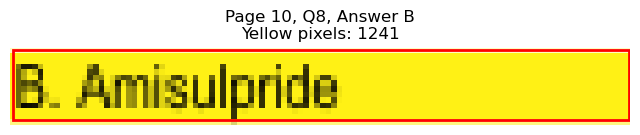

Page 10, Q8 - C: Detected box: x0=315.4, y0=531.2, x1=389.7, y1=543.8
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 354
Page 10, Q8, C: Yellow percentage: 0.0%


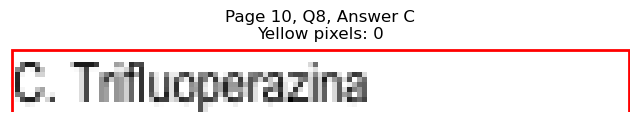

Page 10, Q8 - D: Detected box: x0=315.4, y0=543.8, x1=388.7, y1=556.4
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 359
Page 10, Q8, D: Yellow percentage: 0.0%


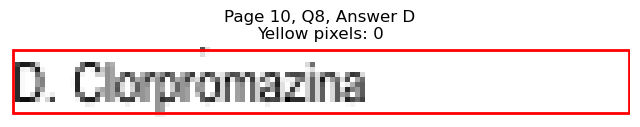


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)
Page 10, Q9 - A: Detected box: x0=56.6, y0=581.7, x1=159.1, y1=594.3
Page 10, Q9, A: Yellow pixels: 1489
Page 10, Q9, A: Total non-white pixels: 2156
Page 10, Q9, A: Yellow percentage: 69.1%


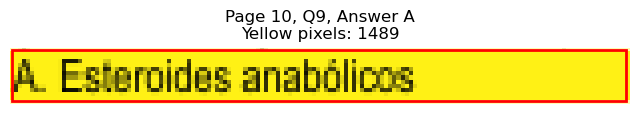

Page 10, Q9 - B: Detected box: x0=56.6, y0=594.3, x1=109.5, y1=606.9
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 365
Page 10, Q9, B: Yellow percentage: 0.0%


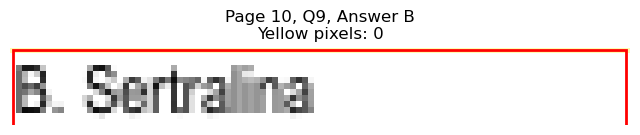

Page 10, Q9 - C: Detected box: x0=315.4, y0=581.7, x1=375.7, y1=594.3
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 303
Page 10, Q9, C: Yellow percentage: 0.0%


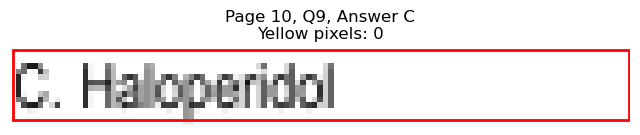

Page 10, Q9 - D: Detected box: x0=315.4, y0=594.3, x1=368.7, y1=606.9
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 260
Page 10, Q9, D: Yellow percentage: 0.0%


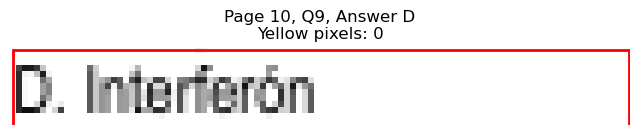


Page 10, Q9 - Selected Answer: A (based on yellow pixel count)
Page 10, Q10 - A: Detected box: x0=56.6, y0=682.6, x1=133.5, y1=695.3
Page 10, Q10, A: Yellow pixels: 0
Page 10, Q10, A: Total non-white pixels: 393
Page 10, Q10, A: Yellow percentage: 0.0%


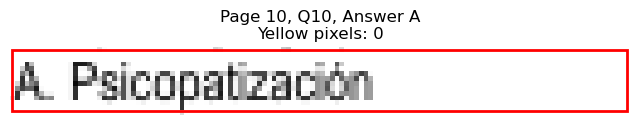

Page 10, Q10 - B: Detected box: x0=56.6, y0=695.4, x1=163.1, y1=708.0
Page 10, Q10, B: Yellow pixels: 1618
Page 10, Q10, B: Total non-white pixels: 2059
Page 10, Q10, B: Yellow percentage: 78.6%


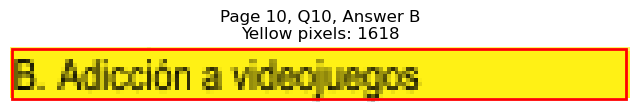

Page 10, Q10 - C: Detected box: x0=315.4, y0=682.6, x1=386.2, y1=695.3
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 339
Page 10, Q10, C: Yellow percentage: 0.0%


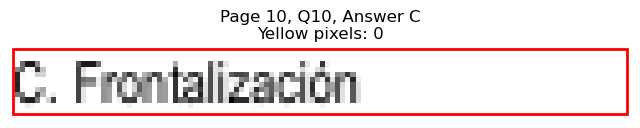

Page 10, Q10 - D: Detected box: x0=315.4, y0=695.4, x1=409.7, y1=708.0
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 452
Page 10, Q10, D: Yellow percentage: 0.0%


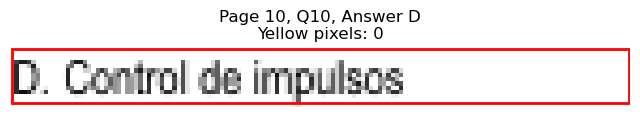


Page 10, Q10 - Selected Answer: B (based on yellow pixel count)
Page 10, Q11 - A: Detected box: x0=56.6, y0=745.8, x1=102.4, y1=758.4
Page 10, Q11, A: Yellow pixels: 0
Page 10, Q11, A: Total non-white pixels: 222
Page 10, Q11, A: Yellow percentage: 0.0%


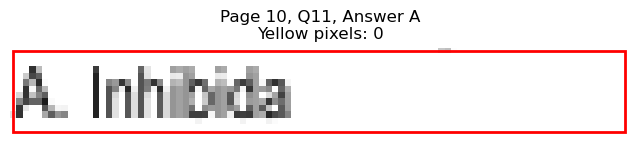

Page 10, Q11 - B: Detected box: x0=56.6, y0=758.5, x1=104.9, y1=771.1
Page 10, Q11, B: Yellow pixels: 1109
Page 10, Q11, B: Total non-white pixels: 1386
Page 10, Q11, B: Yellow percentage: 80.0%


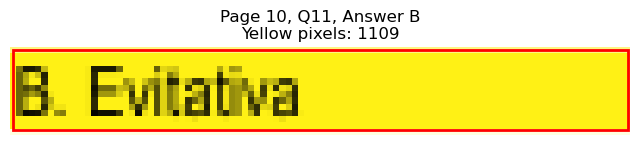

Page 10, Q11 - C: Detected box: x0=315.4, y0=745.8, x1=381.2, y1=758.4
Page 10, Q11, C: Yellow pixels: 0
Page 10, Q11, C: Total non-white pixels: 325
Page 10, Q11, C: Yellow percentage: 0.0%


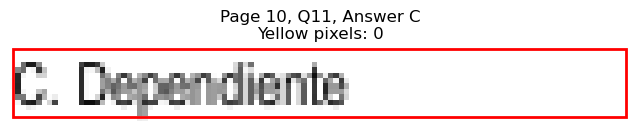

Page 10, Q11 - D: Detected box: x0=315.4, y0=758.5, x1=355.2, y1=771.1
Page 10, Q11, D: Yellow pixels: 0
Page 10, Q11, D: Total non-white pixels: 189
Page 10, Q11, D: Yellow percentage: 0.0%


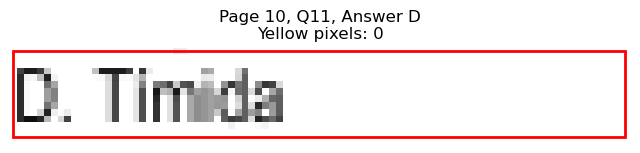


Page 10, Q11 - Selected Answer: B (based on yellow pixel count)

Page 11: Found 1 questions
Page 11, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=102.4, y1=127.3
Page 11, Q1, A: Yellow pixels: 995
Page 11, Q1, A: Total non-white pixels: 1358
Page 11, Q1, A: Yellow percentage: 73.3%


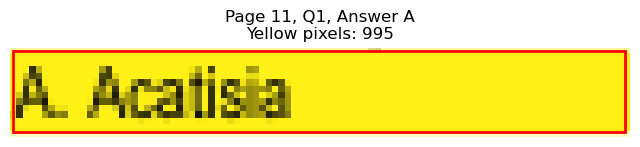

Page 11, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=107.9, y1=139.9
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 344
Page 11, Q1, B: Yellow percentage: 0.0%


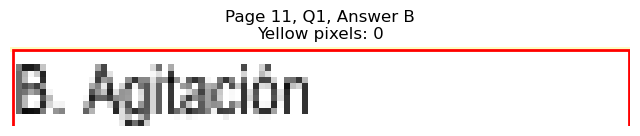

Page 11, Q1 - C: Detected box: x0=56.6, y0=139.9, x1=98.9, y1=152.6
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 199
Page 11, Q1, C: Yellow percentage: 0.0%


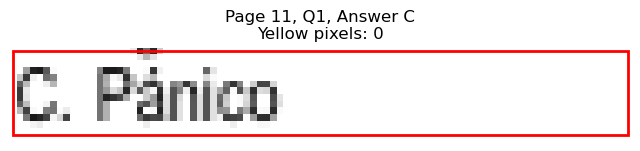

Page 11, Q1 - D: Detected box: x0=56.6, y0=152.5, x1=123.4, y1=165.2
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 299
Page 11, Q1, D: Yellow percentage: 0.0%


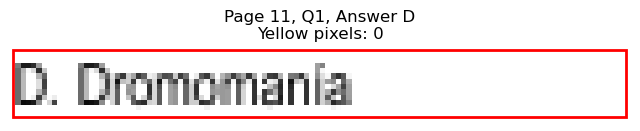


Page 11, Q1 - Selected Answer: A (based on yellow pixel count)


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Juana de 33 años, acude a la entrevista con su...
1   Varón de 32 años, con historia de relaciones i...
2   Varón \nde \n13 años, \nacude \na emergencia \...
3   ¿Cuál es el inhibidor de la recaptación de ser...
4   Rosa, puérpera de 20 días, con diagnóstico de ...
..                                                ...
95  Juan de 54 años, con antecedente de insuficien...
96  ¿Cuál de los siguientes fármacos puede inducir...
97  Mujer de 21 años, desde hace 3 años usa videoj...
98  ¿Cuál es el trastorno de personalidad que mues...
99  Varón de 25 años con diagnóstico reciente de e...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                    Hiperactividad   
1                Familiar sistémica   
2   Apoyo psicológico de emergencia   
3                        Paroxetina   
4                         Sulpiride   
..                              ...   
95                      Flufenazina   
96            Esteroides anabólicos   
97                  Psicopatización   
98                         Inhibida   
99                         Acatisia   

                                      option_B  \
0                            Masoquismo sexual   
1                        Dialéctico conductual   
2   Clonazepam 2 mg cada 24 horas por 1 semana   
3                               Desvenlafaxina   
4                                    Clozapina   
..                                         ...   
95                                 Amisulpride   
96                                  Sertralina   
97                      Adicción a videojuegos   
98                                   Evitativa   
99                                   Agitación   

                                         option_C  \
0                                     Froteurismo   
1                                       Eneagrama   
2   Psicoterapia de afronte del evento traumático   
3                                      Sertralina   
4                                      Sertralina   
..                                            ...   
95                                Trifluoperazina   
96                                    Haloperidol   
97                                 Frontalización   
98                                    Dependiente   
99                                         Pánico   

                                      option_D  
0                                   Voyeurismo  
1                               Psicoanalítica  
2   Alprazolam 0.5 mg cada 12 horas por 3 días  
3                                 Escitalopram  
4                                   Olanzapina  
..                                         ...  
95                               Clorpromazina  
96                                  Interferón  
97                         Control de impulsos  
98                                      Tímida  
99                                  Dromomanía  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Juana de 33 años, acude a la entrevista con su...   
1   Varón de 32 años, con historia de relaciones i...   
2   Varón \nde \n13 años, \nacude \na emergencia \...   
3   ¿Cuál es el inhibidor de la recaptación de ser...   
4   Rosa, puérpera de 20 días, con diagnóstico de ...   
..                                                ...   
95  Juan de 54 años, con antecedente de insuficien...   
96  ¿Cuál de los siguientes fármacos puede inducir...   
97  Mujer de 21 años, desde hace 3 años usa videoj...   
98  ¿Cuál es el trastorno de personalidad que mues...   
99  Varón de 25 años con diagnóstico reciente de e...   

                           option_A  \
0                    Hiperactividad   
1                Familiar sistémica   
2   Apoyo psicológico de emergencia   
3                        Paroxetina   
4                         Sulpiride   
..                              ...   
95                      Flufenazina   
96            Esteroides anabólicos   
97                  Psicopatización   
98                         Inhibida   
99                         Acatisia   

                                      option_B  \
0                            Masoquismo sexual   
1                        Dialéctico conductual   
2   Clonazepam 2 mg cada 24 horas por 1 semana   
3                               Desvenlafaxina   
4                                    Clozapina   
..                                         ...   
95                                 Amisulpride   
96                                  Sertralina   
97                      Adicción a videojuegos   
98                                   Evitativa   
99                                   Agitación   

                                         option_C  \
0                                     Froteurismo   
1                                       Eneagrama   
2   Psicoterapia de afronte del evento traumático   
3                                      Sertralina   
4                                      Sertralina   
..                                            ...   
95                                Trifluoperazina   
96                                    Haloperidol   
97                                 Frontalización   
98                                    Dependiente   
99                                         Pánico   

                                      option_D correct_answer  
0                                   Voyeurismo              B  
1                               Psicoanalítica              B  
2   Alprazolam 0.5 mg cada 12 horas por 3 días              A  
3                                 Escitalopram              A  
4                                   Olanzapina              D  
..                                         ...            ...  
95                               Clorpromazina              B  
96                                  Interferón              A  
97                         Control de impulsos              B  
98                                      Tímida              B  
99                                  Dromomanía              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/PSIQUIATRÍA.csv
